This notebook estimates the parameters for the three state model usign the Approximate Bayesian Calculation implemented in PyMC

In [160]:
import os
from numba import njit
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from scipy.integrate import odeint
from matplotlib.widgets import Button, Slider
print(f"Running on PyMC v{pm.__version__}")
plt.rcParams['text.usetex'] = True

Running on PyMC v5.10.4


In [101]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [102]:
# SET THE WORKING DIRECTORY
CWD = '/Users/miguel/Documents/Internship_CENTURI'
os.chdir(CWD)
## DEFINES WORKING CONSTANTS
#FILENAME = args.filename
FILENAME = 'plate_counts.csv'
SAVE_FN = FILENAME.strip().split('.')[0]


In [236]:
class EvolutionExperiment():
    '''
    Takes as input:
        name: name of the model
        t: time array
        params: dictionary with 5 parameters, the replication rates(r_f,r_c), transition rates(mu_fc, mu_cf), carrying capacity(K)
        p0: inital point
        p1: initial point for the subsequent runs of the evolution experiment
    '''
    # For the equations I will take the time to be in minutes, considering that the replication rates found are in minutes
    # Since each experiment lasts a day, I will asume the time interval to be 24*60 long
    
    def __init__(self, strain_name, number_days, model_params, dilution_percentage = 1e-3) -> None:
        
        # Parameters of the model
        # The default for the transition rates is the value from
        # Mutations per generation for wild type (https://doi.org/10.1093/gbe/evu284)
        self.r_f = model_params.get('r_f', 0.04060)                         # Founder's replication rate
        self.r_d = model_params.get('r_d', 0.05448)                         # Duplication's replication rate
        self.r_s = model_params.get('r_s', 0.01)                            # SNP mutation replication rate
        self.__mu_fd = model_params.get('mu_fd', 4.25e-9) / np.log(2)       # Transition rate F->D
        self.__mu_fs = model_params.get('mu_fs', 4.25e-9) / np.log(2)       # Transition rate F->S
        self.__mu_df = model_params.get('mu_df', 4.25e-9) / np.log(2)       # Transition rate D->F
        self.__mu_sf = model_params.get('mu_sf', 4.25e-9) / np.log(2)       # Transition rate S->F
        self.K = model_params.get('K', 1e2)                                 # Carrying capacity, 10^10 for the experiment
        self.strain_name = strain_name
        self.number_days = number_days
        self.dilution_percentage = dilution_percentage
        self.day = 0
        self.days_experiment = 0                                            # Stores the days that have experimental daya for inference tasks
        self.daily_fraction = np.zeros((self.number_days, 3))
        self.time_interval = np.arange(0, int(24 * 60 * self.r_f))
        self.history = np.zeros((self.number_days, self.time_interval.shape[0], 3))
        self.__frac = 0
        self.p0 = 0
        self.__p1 = 0
        self.__alpha = self.r_d / self.r_f
        self.__beta = self.r_s / self.r_f
        
        

        # Solution of the model
        self.sol = 0
    
    #Private variables from the class
    @property
    def frac(self):
        temp_frac = self.sol / self.sol.sum(axis = 1)[:, None]
        self.__frac = temp_frac
        return self.__frac
    @property
    def p1(self):
        return self.__p1
    
    @p1.setter
    def p1(self, value):
        self.__p1 = value
    
    @property
    def alpha(self):
        return self.__alpha
    
    @alpha.setter
    def alpha(self, value):
        if value is not None:
            self.__alpha = value
        else:
            self.__alpha = self.r_d / self.r_f
    
    @property
    def beta(self):
        return self.__beta
    
    @beta.setter
    def beta(self, value):
        if value is not None:
            self.__beta = value
        else:
            self.__beta = self.r_s / self.r_f
    @property
    def mu_fd(self):
        return self.__mu_fd
    
    @mu_fd.setter
    def mu_fd(self, value):
        self.__mu_fd = value / np.log(2)
    
    @property
    def mu_fs(self):
        return self.__mu_fs
    
    @mu_fs.setter
    def mu_fs(self, value):
        self.__mu_fs = value / np.log(2)
    
    @property
    def mu_df(self):
        return self.__mu_df
    
    @mu_df.setter
    def mu_df(self, value):
        self.__mu_df = value / np.log(2)
    
    @property
    def mu_sf(self):
        return self.__mu_sf
    
    @mu_sf.setter
    def mu_sf(self, value):
        self.__mu_sf = value / np.log(2)

    def model(self, vars, t):
        #Unpack the variables
        F, D, S = vars
        # Define the system of equations     
        M = np.array([self.r_f * (1 - self.mu_fd + self.mu_fs) * F + self.mu_df * self.r_d * D +  self.mu_sf * self.r_s * S,
                      self.r_f * self.mu_fd * F + self.r_d * (1 - self.mu_df) * D,
                      self.r_f * self.mu_fs * F + self.r_s * (1 - self.mu_sf) * D])
        return M * (1- (F + D + S) / self.K)
    
    def adim_model(self, vars, t):
        #Unpack the variables
        F, D, S = vars
        # Define the system of equations     
        M = np.array([(1 - self.mu_fd + self.mu_fs) * F + self.mu_df * self.alpha * D +  self.mu_sf * self.beta * S,
                      self.mu_fd * F + self.alpha * (1 - self.mu_df) * D,
                      self.mu_fs * F + self.beta * (1 - self.mu_sf) * D])
        return M * (1- (F + D + S) / self.K)
     
    def solve(self):
        # Solve the system
        sol = odeint(self.adim_model, y0 = self.__p1, t = self.time_interval)
        self.sol = sol
    
    def run_experiment(self):
        #print("Running the evolution experiment")
        self.__p1 = self.p0.copy()
        for day in np.arange(self.number_days):
            self.solve()
            self.history[day] = self.sol
            self.__p1 = self.sol[-1] * self.dilution_percentage
            self.daily_fraction[day] = self.sol[-1] / self.sol[-1].sum()
            self.day += 1

    def run_experiment_for_inference(self, rng, new_alpha, new_beta, new_mu_fd, new_mu_fs, new_mu_df, new_r_s, size = None):
        #print("Running the evolution experiment")
        # Updates the parameters
        self.alpha = new_alpha
        self.beta = new_beta
        self.r_s = new_r_s
        self.mu_fd = new_mu_fd
        self.mu_fs = new_mu_fs
        self.mu_df = new_mu_df
        self.__p1 = self.p0.copy()
        for day in np.arange(self.number_days):
            self.solve()
            self.history[day] = self.sol
            self.__p1 = self.sol[-1] * self.dilution_percentage
            self.daily_fraction[day] = self.sol[-1] / self.sol[-1].sum()
            self.day += 1
        
        #return np.stack((self.daily_fraction[:, 0], self.daily_fraction[:, 1:].sum(axis = 1)), axis = 1)[self.days_experiment, :]
        return self.daily_fraction[:, 0][self.days_experiment]

    def plot_sol(self, ax):
        ax.plot(EvolutionExperiment.time_interval, self.sol, label = ['F', 'C'])
        ax.set_title(self.name)
        #ax.set_ylabel('Population(x10^8)')
        #ax.set_xlabel('Time')
        ax.legend()
        return ax
    
    def plot_frac(self, ax):
        temp_frac = self.sol / self.sol.sum(axis = 1)[:, None]
        ax.plot(self.time, temp_frac, label = ['F', 'C'])
        ax.set_title(self.name)
        #ax.set_ylabel('Population(x10^8)')
        #ax.set_xlabel('Time')
        ax.legend()
        return ax

    def plot_evolution_frac(self, interactive = False):
        days = np.arange(self.number_days)
        large_frac = self.daily_fraction[:, 1] + self.daily_fraction[:, 2]
        fig, ax = plt.subplots(figsize = (11, 6))

        founder_line = ax.plot(days, self.daily_fraction[:, 0], label = 'Founder')[0]
        large_fraction_line = ax.plot(days, large_frac, label = 'Duplication + SNP')
        duplication_line = ax.plot(days, self.daily_fraction[:, 1], '--' ,label = 'Duplication')[0]
        snp_line = ax.plot(days, self.daily_fraction[:, 2], '--', label = 'SNP')[0]
        ax.set_title(self.strain_name);
        ax.set_ylabel('Population fraction');
        ax.set_xlabel('Day');
        ax.legend();

        if interactive:
            fig.subplots_adjust(left = 0.1, bottom = 0.3)

            # Make a horizontal slider to control the frequency.
            ax_alpha = fig.add_axes([0.15, 0.1, 0.65, 0.03])
            alpha_slider = Slider(
                ax = ax_alpha,
                label = r'$r_M$',
                valmin = 0,
                valmax = 2,
                valinit = 1,
                #valinit = 1
            )
            ax_mu_fd = fig.add_axes([0.15, 0.15, 0.65, 0.03])
            mu_fd_slider = Slider(
                ax = ax_mu_fd,
                label = r'$\mu_{F\rightarrow D}$',
                valmin = 1e-11,
                valmax = 1e-6,
                valinit = 1e-9,
            )
            # Make a vertically oriented slider to control the amplitude
            ax_mu_df = fig.add_axes([0.15, 0.20, 0.65, 0.03])
            mu_df_slider = Slider(
                ax = ax_mu_df,
                label = r'$\mu_{D\rightarrow F}$',
                valmin = 4.25e-3,
                valmax = 4.25e-2,
                valinit = self.mu_df,
            )
            # The function to be called anytime a slider's value changes
            def update(val):
                self.mu_fd = mu_fd_slider.val
                self.mu_df = mu_df_slider.val
                #self.__alpha = alpha_slider.val
                self.run_experiment()
                founder_line.set_ydata(self.daily_fraction[:, 0])
                duplication_line.set_ydata(self.daily_fraction[:, 1])
                snp_line.set_ydata(self.daily_fraction[:, 2])
                large_fraction_line.set_ydata(self.daily_fraction[:, 1] + self.daily_fraction[:, 2])
                fig.canvas.draw_idle()
                fig.canvas.flush_events()
            
            # The function to be called upon pressing the reset button
            def reset(event):
                mu_fd_slider.reset()
                mu_df_slider.reset()
                alpha_slider.reset()
                print("RESET")
                print(self.mu_cf)
                print(self.mu_fc)
                self.run_experiment()
                fig.canvas.draw_idle()
                fig.canvas.flush_events()
                

            # Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
            resetax = fig.add_axes([0.8, 0.05, 0.1, 0.04])
            button = Button(resetax, 'Reset', hovercolor='0.975')

            # register the update function with each slider
            mu_fd_slider.on_changed(update)
            mu_df_slider.on_changed(update)
            alpha_slider.on_changed(update)
            
            button.on_clicked(reset)
        #plt.show()
            
            return ax, button
        
        return ax
    

    def __str__(self) -> str:
        return "name : {} \nparameters (r_f : {}, mu_fc : {}, r_c : {}, mu_cf : {}, K : {}) \n \
                ".format(self.strain_name, self.r_f, self.mu_fc, self.r_c, self.mu_cf, self.K)



In [221]:
# Read experimental data for inference
df = pd.read_csv('/Users/miguel/Documents/Internship_CENTURI/data/plate_counts.csv')
df = df.sort_values(['founder', 'replicate']).reset_index(drop=True)
temp_df = df[(df.founder=='delserCGA') & (df.replicate == 1)]

x = temp_df.day.values
y = temp_df[['frac_small']].values

test_p0 = np.array([0.001, 0, 0])
num_days = 101
# When using delserCGA the replication rate of the founder is found using the growth curve fits
# Additionally, the replication rate of the mutant is assumed to be the rate of M2lop obtained with the gc fit
# The number of days in the experiment is 100, for testing let's assume 10
# M2lop replication rate : 0.05447838370459147
# delserCGA replication rate : 0.04060341705556068
# Mutations per generation for wild type (https://doi.org/10.1093/gbe/evu284)
# 4.25e-9
# Using the same value for all as a proxy

test_params = {'r_f' : 0.04060, 'r_d' : 0.05448, 'r_s' : 0.035, 'mu_fd' : 4.25e-9, 'mu_fs' : 4.25e-3, 'mu_df' : 4.25e-9, 'mu_sf' : 4.25e-9, 'K' : 1e2}
model_experiment = EvolutionExperiment('delserCGA', num_days , test_params, dilution_percentage= 1e-2)
model_experiment.days_experiment = x
model_experiment.p0 = test_p0
#model_experiment.p1 = test_p0

#### Testing which definition of the model perfoms the fastest

In [115]:
from time import perf_counter
model = np.zeros(1000)
model2 = np.zeros(1000)
for i in range(1000):
    t1 = perf_counter()
    model_experiment.run_experiment()
    t2 = perf_counter()
    model[i] = t2 - t1
    #print(f"Run1: {t4 - t3} seconds")

test_params = {'r_f' : 0.04060, 'r_d' : 0.05448, 'r_s' : 0.03, 'mu_fd' : 4.25e-9, 'mu_fs' : 4.25e-9, 'mu_df' : 4.25e-9, 'mu_sf' : 4.25e-9, 'K' : 1e2}
model_experiment = EvolutionExperiment('delserCGA', num_days , test_params)
model_experiment.p0 = test_p0
model_experiment.p1 = test_p0
for i in range(1000):
    t3 = perf_counter()
    model_experiment.run_experiment2()
    t4 = perf_counter()
    model2[i] = t4-t3
    #print(f"Run2: {t4 - t3} seconds")

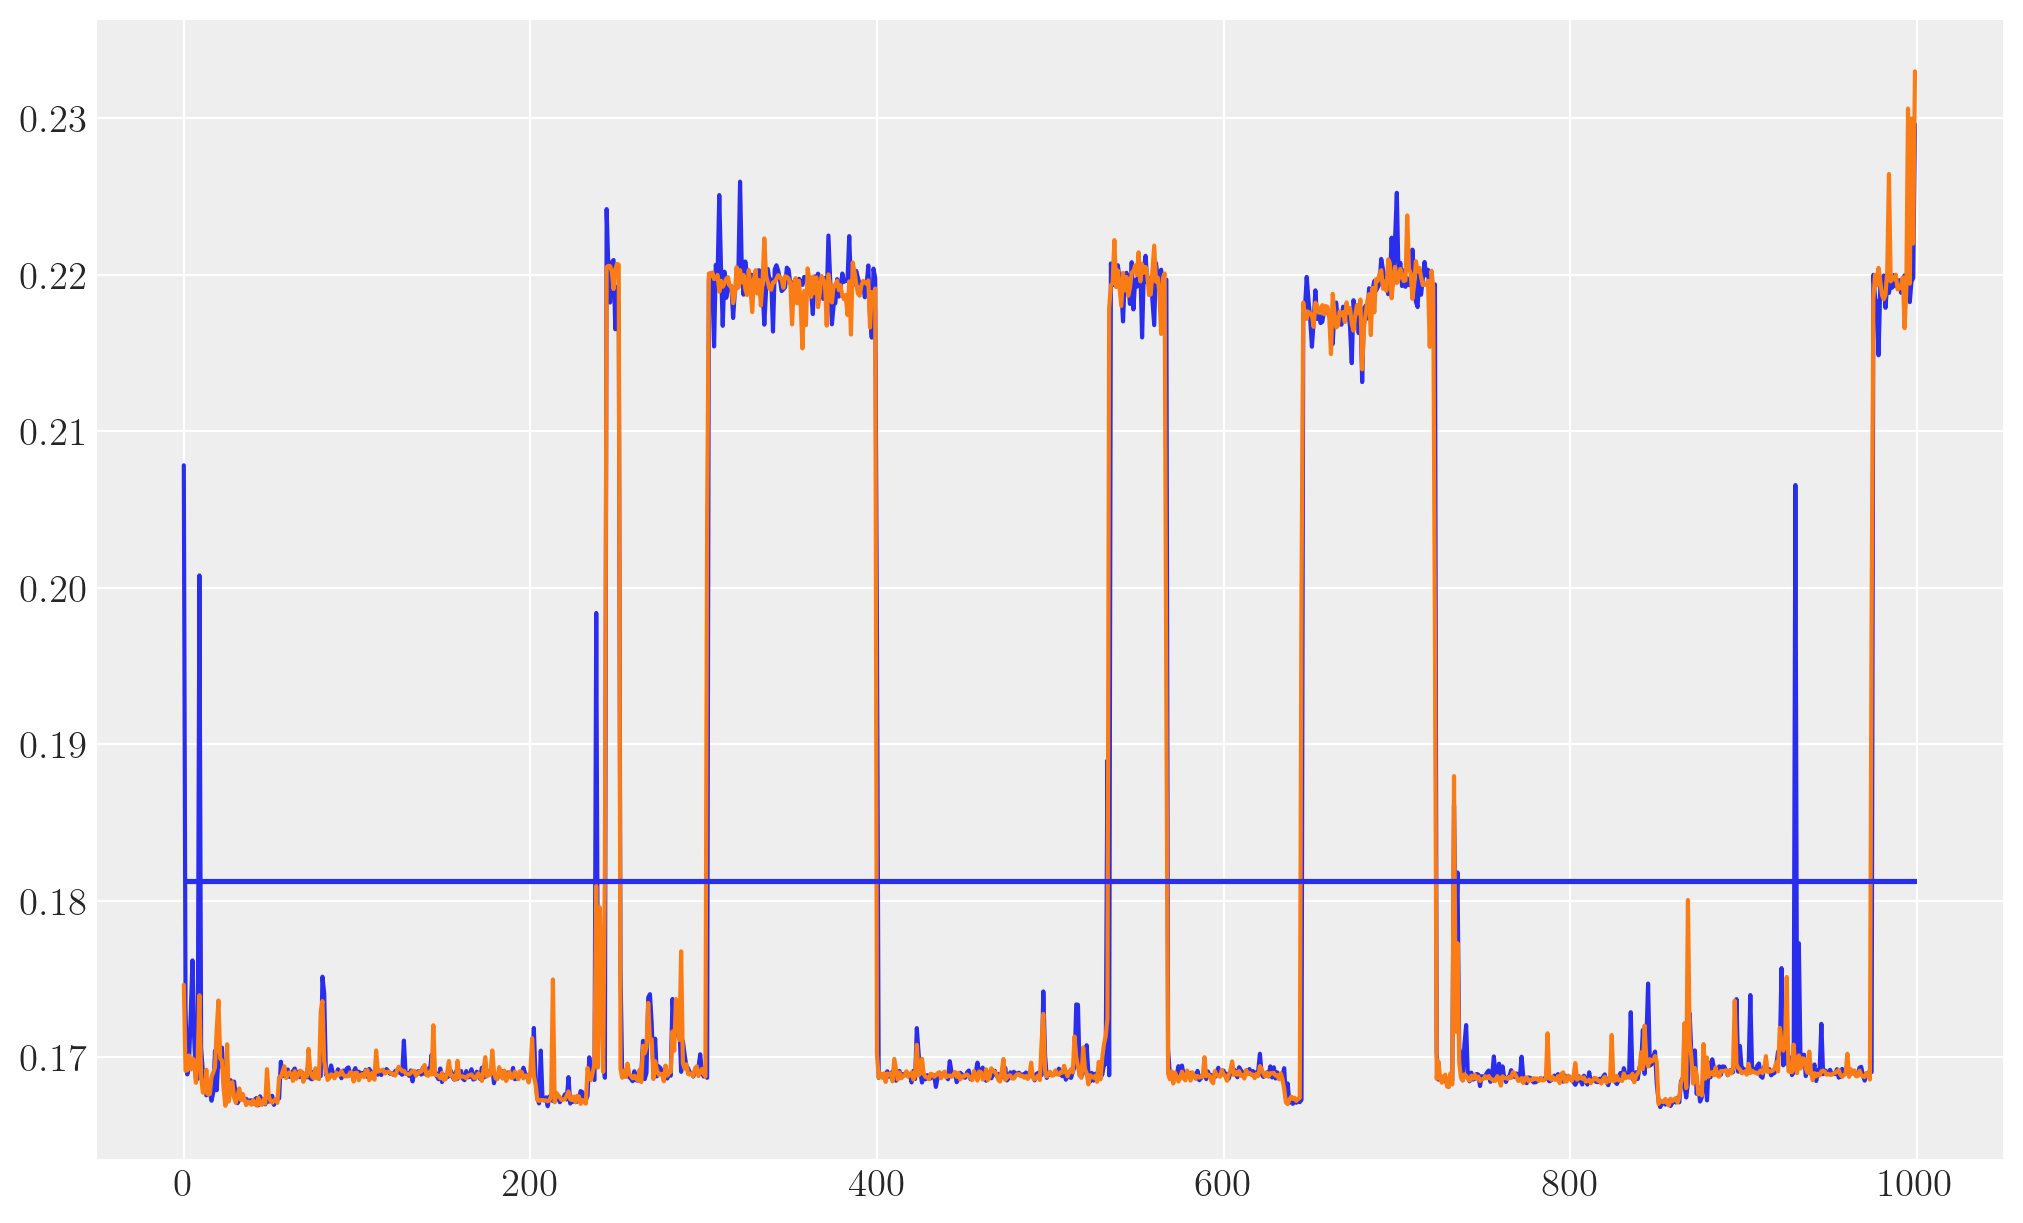

In [89]:
plt.figure(figsize = (10, 6))
plt.plot(model)
plt.plot(model2)
plt.hlines(xmin = 0, xmax = 1000, y = model.mean())
plt.hlines(xmin = 0, xmax = 1000, y = model2.mean())

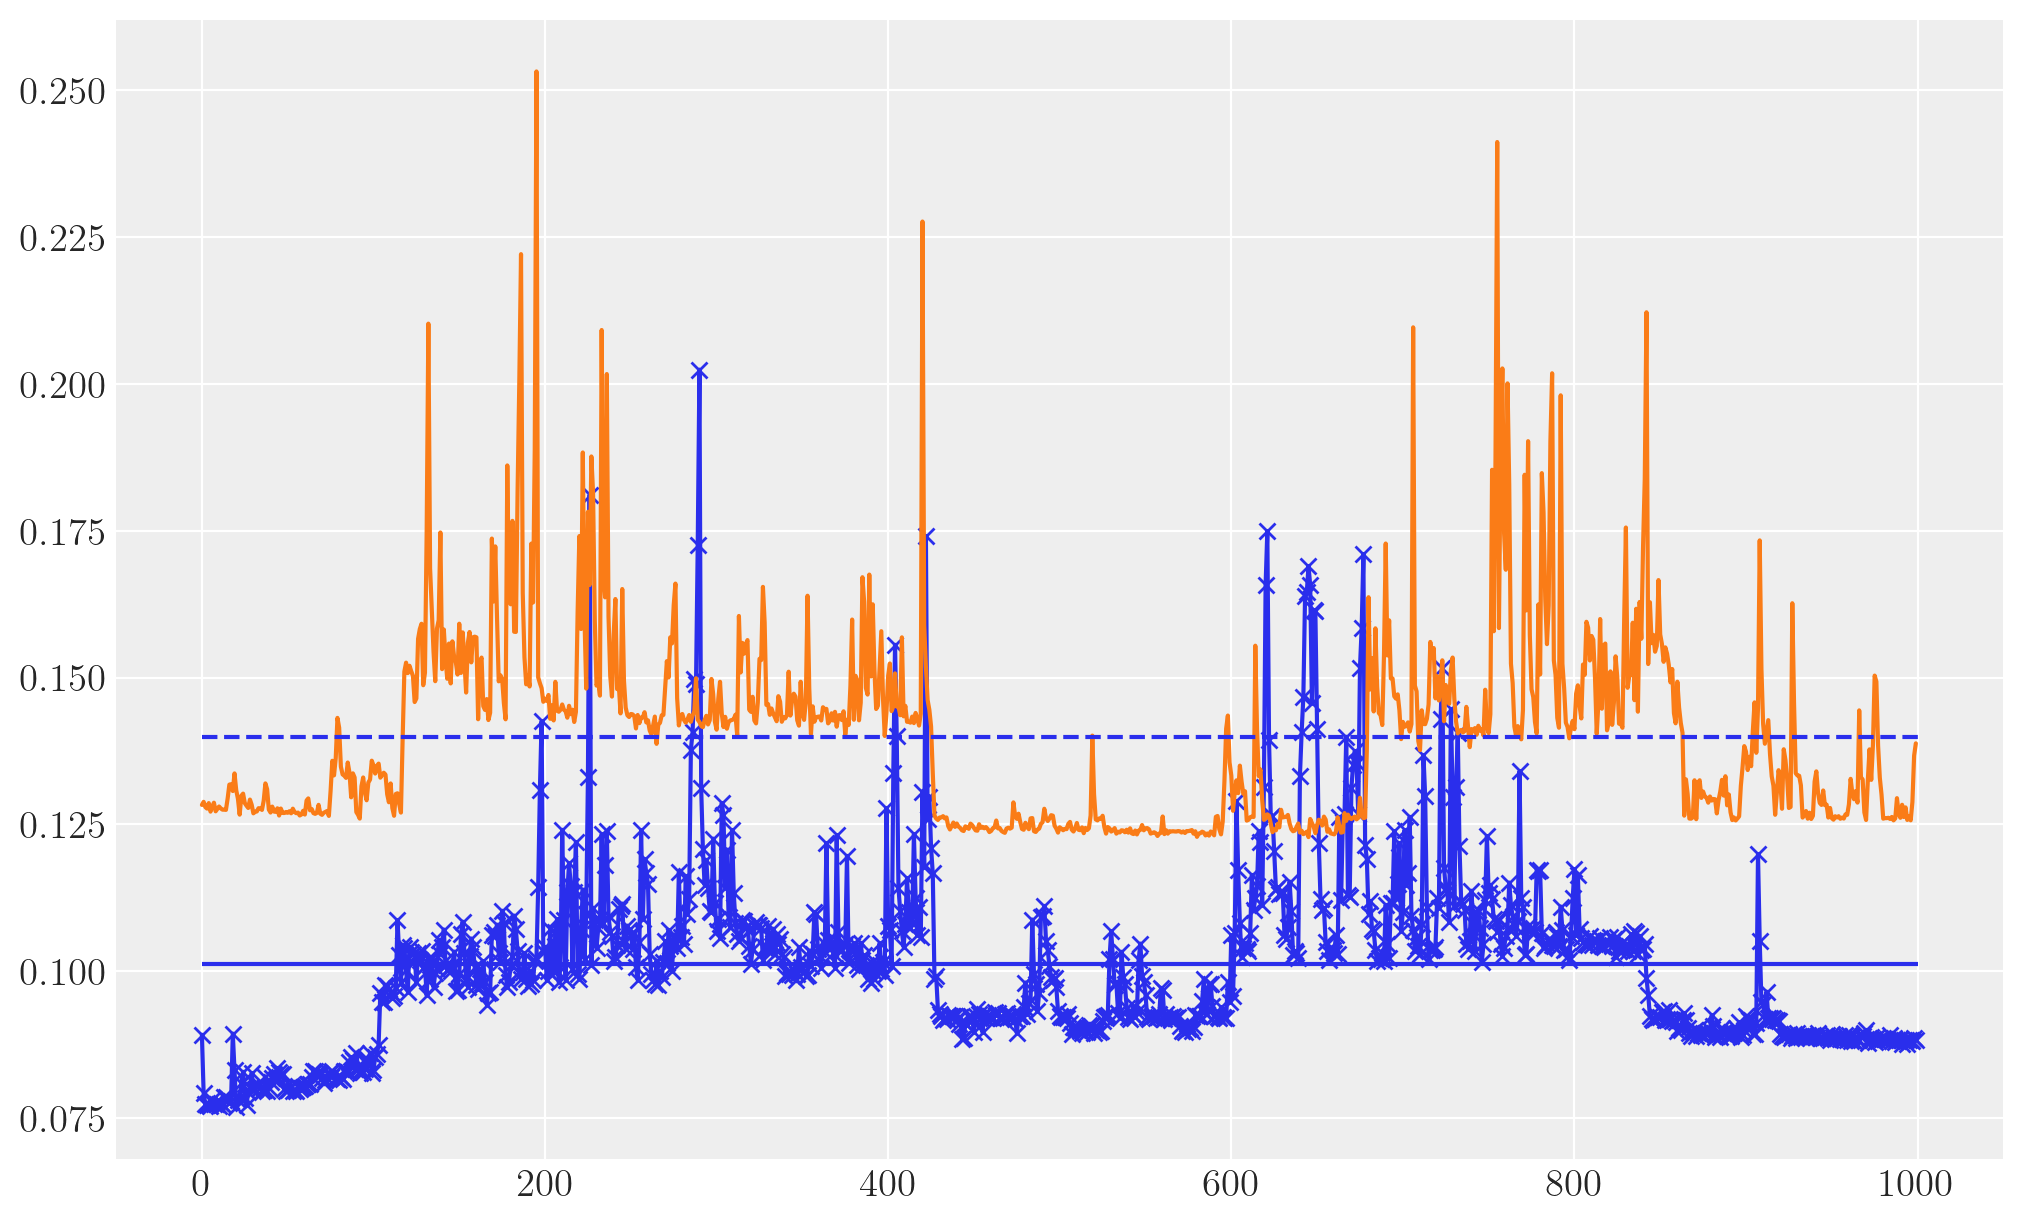

In [116]:
plt.figure(figsize = (10, 6))
plt.plot(model, '-x')
plt.plot(model2)
plt.hlines(xmin = 0, xmax = 1000, y = model.mean())
plt.hlines(xmin = 0, xmax = 1000, y = model2.mean(), linestyles='dashed')

#### Visualizing the evolution experiment results

/var/folders/j5/gzgbj85d7fl1z1qxpqp965kc0000gq/T/ipykernel_38229/2243569261.py:145: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left = 0.1, bottom = 0.3)


AttributeError: 'tuple' object has no attribute 'plot'

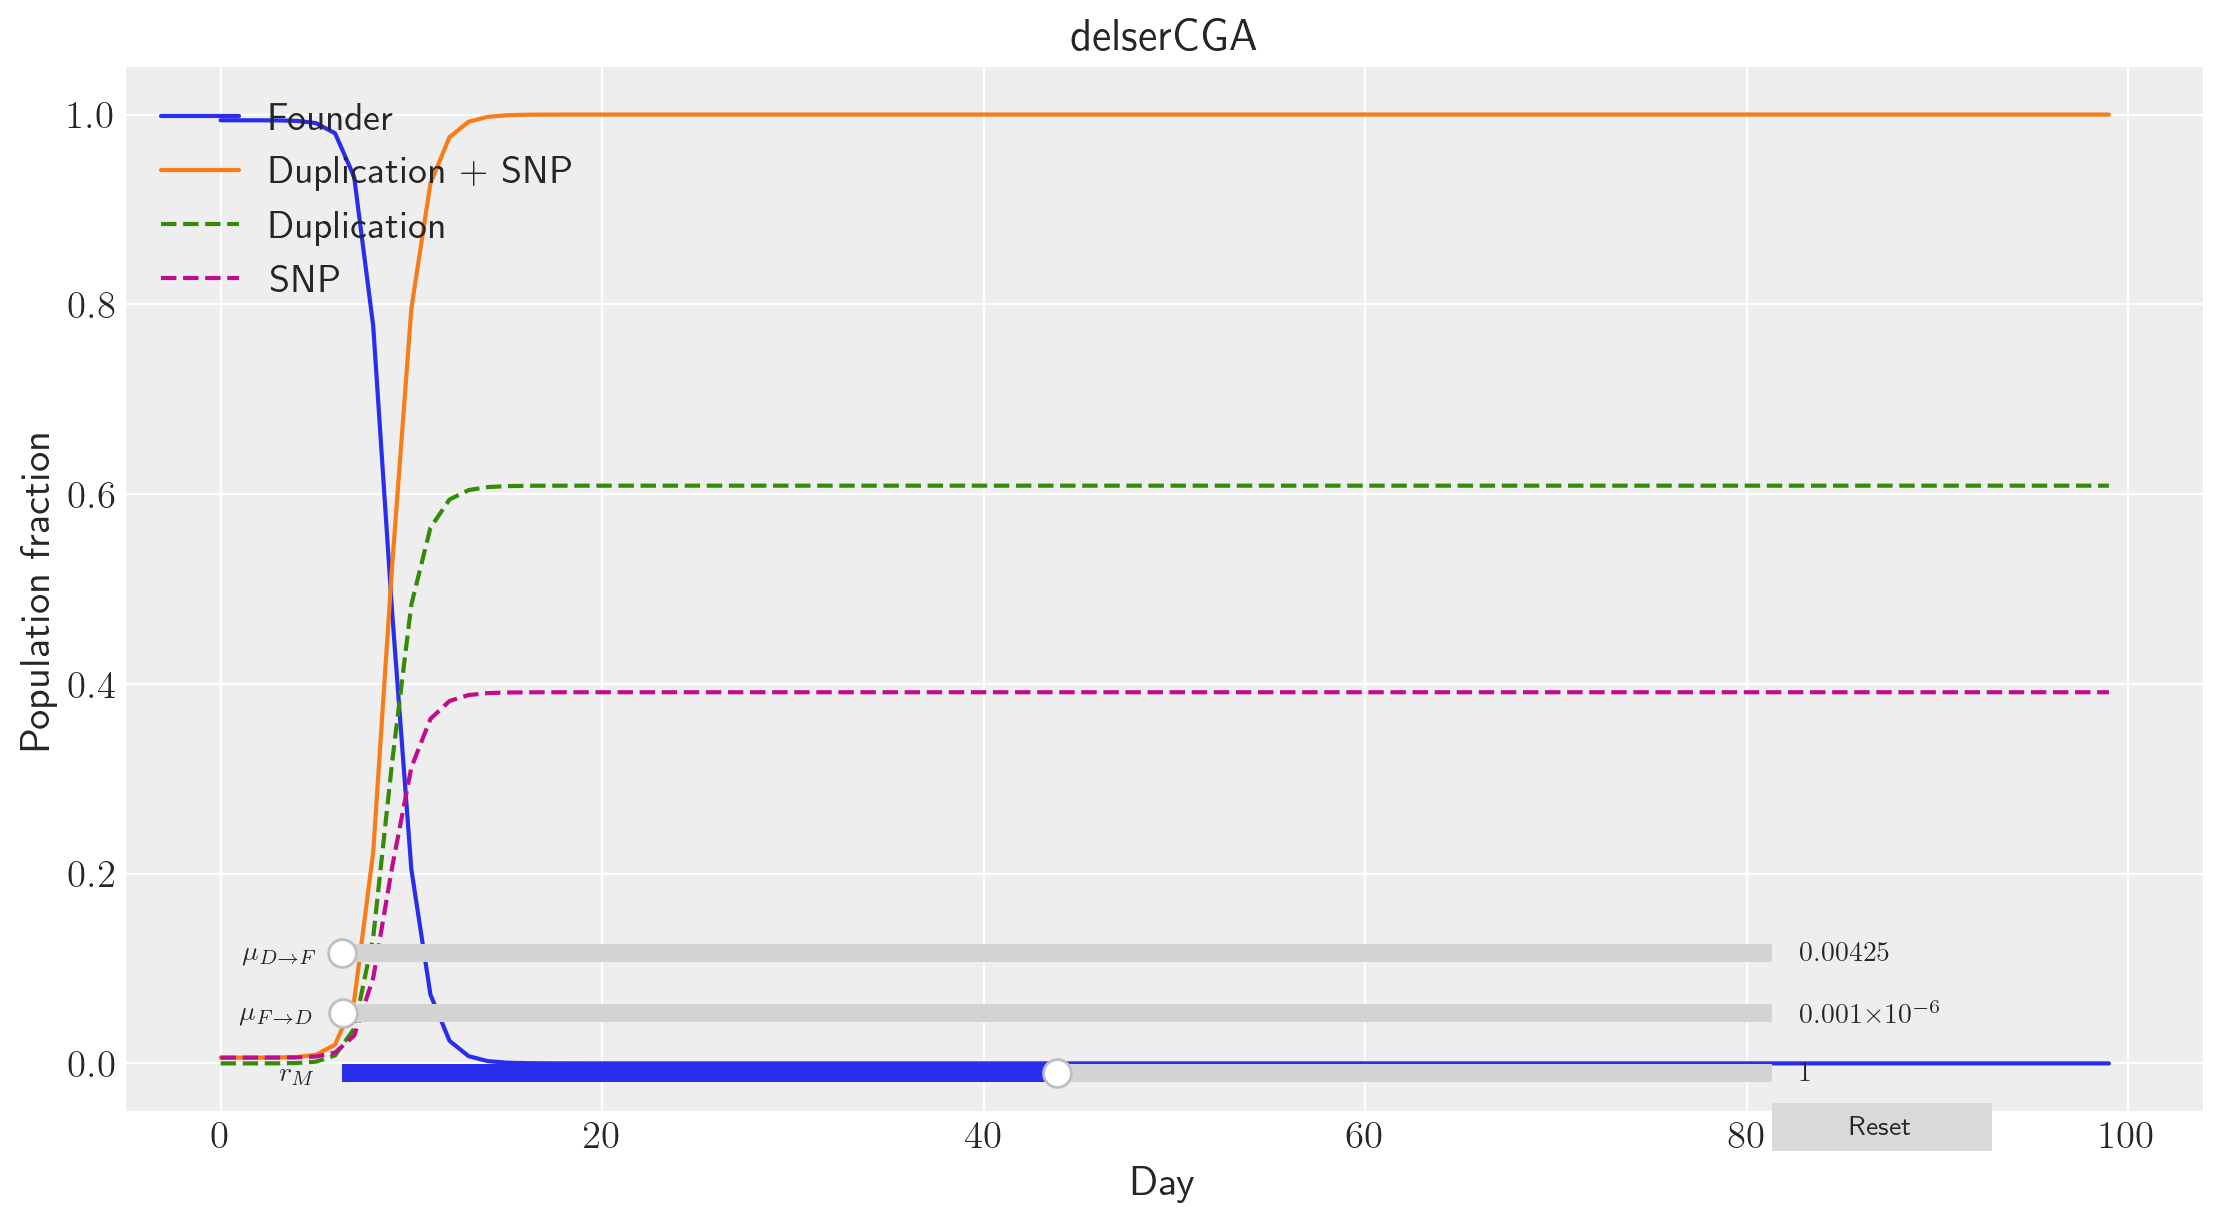

In [177]:
model_experiment.run_experiment()
ax = model_experiment.plot_evolution_frac(interactive = True)

# Comparison with the measurements
df = pd.read_csv('/Users/miguel/Documents/Internship_CENTURI/data/plate_counts.csv')
df = df.sort_values(['founder', 'replicate']).reset_index(drop=True)
temp_df = df[df.founder=='delserCGA']

for i in temp_df.replicate.unique()[:1]:
    temp_df = temp_df[temp_df.replicate == i]
    ax.plot(temp_df.day.values , temp_df.frac_large, 'x', label = f'Replicate {i} large')
    ax.plot(temp_df.day.values , temp_df.frac_small, 'x', label = f'Replicate {i} small')
ax.legend()
plt.show()


In [134]:
temp_df[temp_df.replicate == 1].day.values * model_experiment.time_interval.shape[0]

array([     0,   1440,   2880,   4320,   5760,   7200,   8640,  10080,
        11520,  12960,  14400,  15840,  17280,  18720,  20160,  21600,
        23040,  24480,  25920,  27360,  28800,  30240,  31680,  33120,
        34560,  36000,  37440,  38880,  40320,  43200,  53280,  56160,
        63360,  66240,  72000,  76320,  77760,  79200,  84960,  86400,
        89280,  95040,  96480,  99360, 105120, 106560, 109440, 115200,
       116640, 120960, 122400, 126720, 132480, 136800, 144000])

# Approximate Bayesian Calculation (ABC)
With the defined model above we will run ABC

In [227]:
with pm.Model() as model:
    alpha = pm.Uniform("new_alpha", lower = 1, upper = 2)
    beta = pm.Uniform("new_beta", lower = 1, upper = 2)
    mu_fd = pm.HalfNormal("new_mu_fd", sigma = 1e-4)
    mu_fs = pm.HalfNormal("new_mu_fs", sigma = 1e-4)
    mu_df = pm.HalfNormal("new_mu_df", sigma = 1e-4)
    r_s = pm.HalfNormal("new_r_s", sigma = 1e-3)

    sim = pm.Simulator("sim", model_experiment.run_experiment_for_inference, params = (alpha, beta, mu_fd, mu_fs, mu_df,  r_s), epsilon = 0.1, observed = y.ravel())

    abc_data = pm.sample_smc()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


In [231]:
abc_data

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

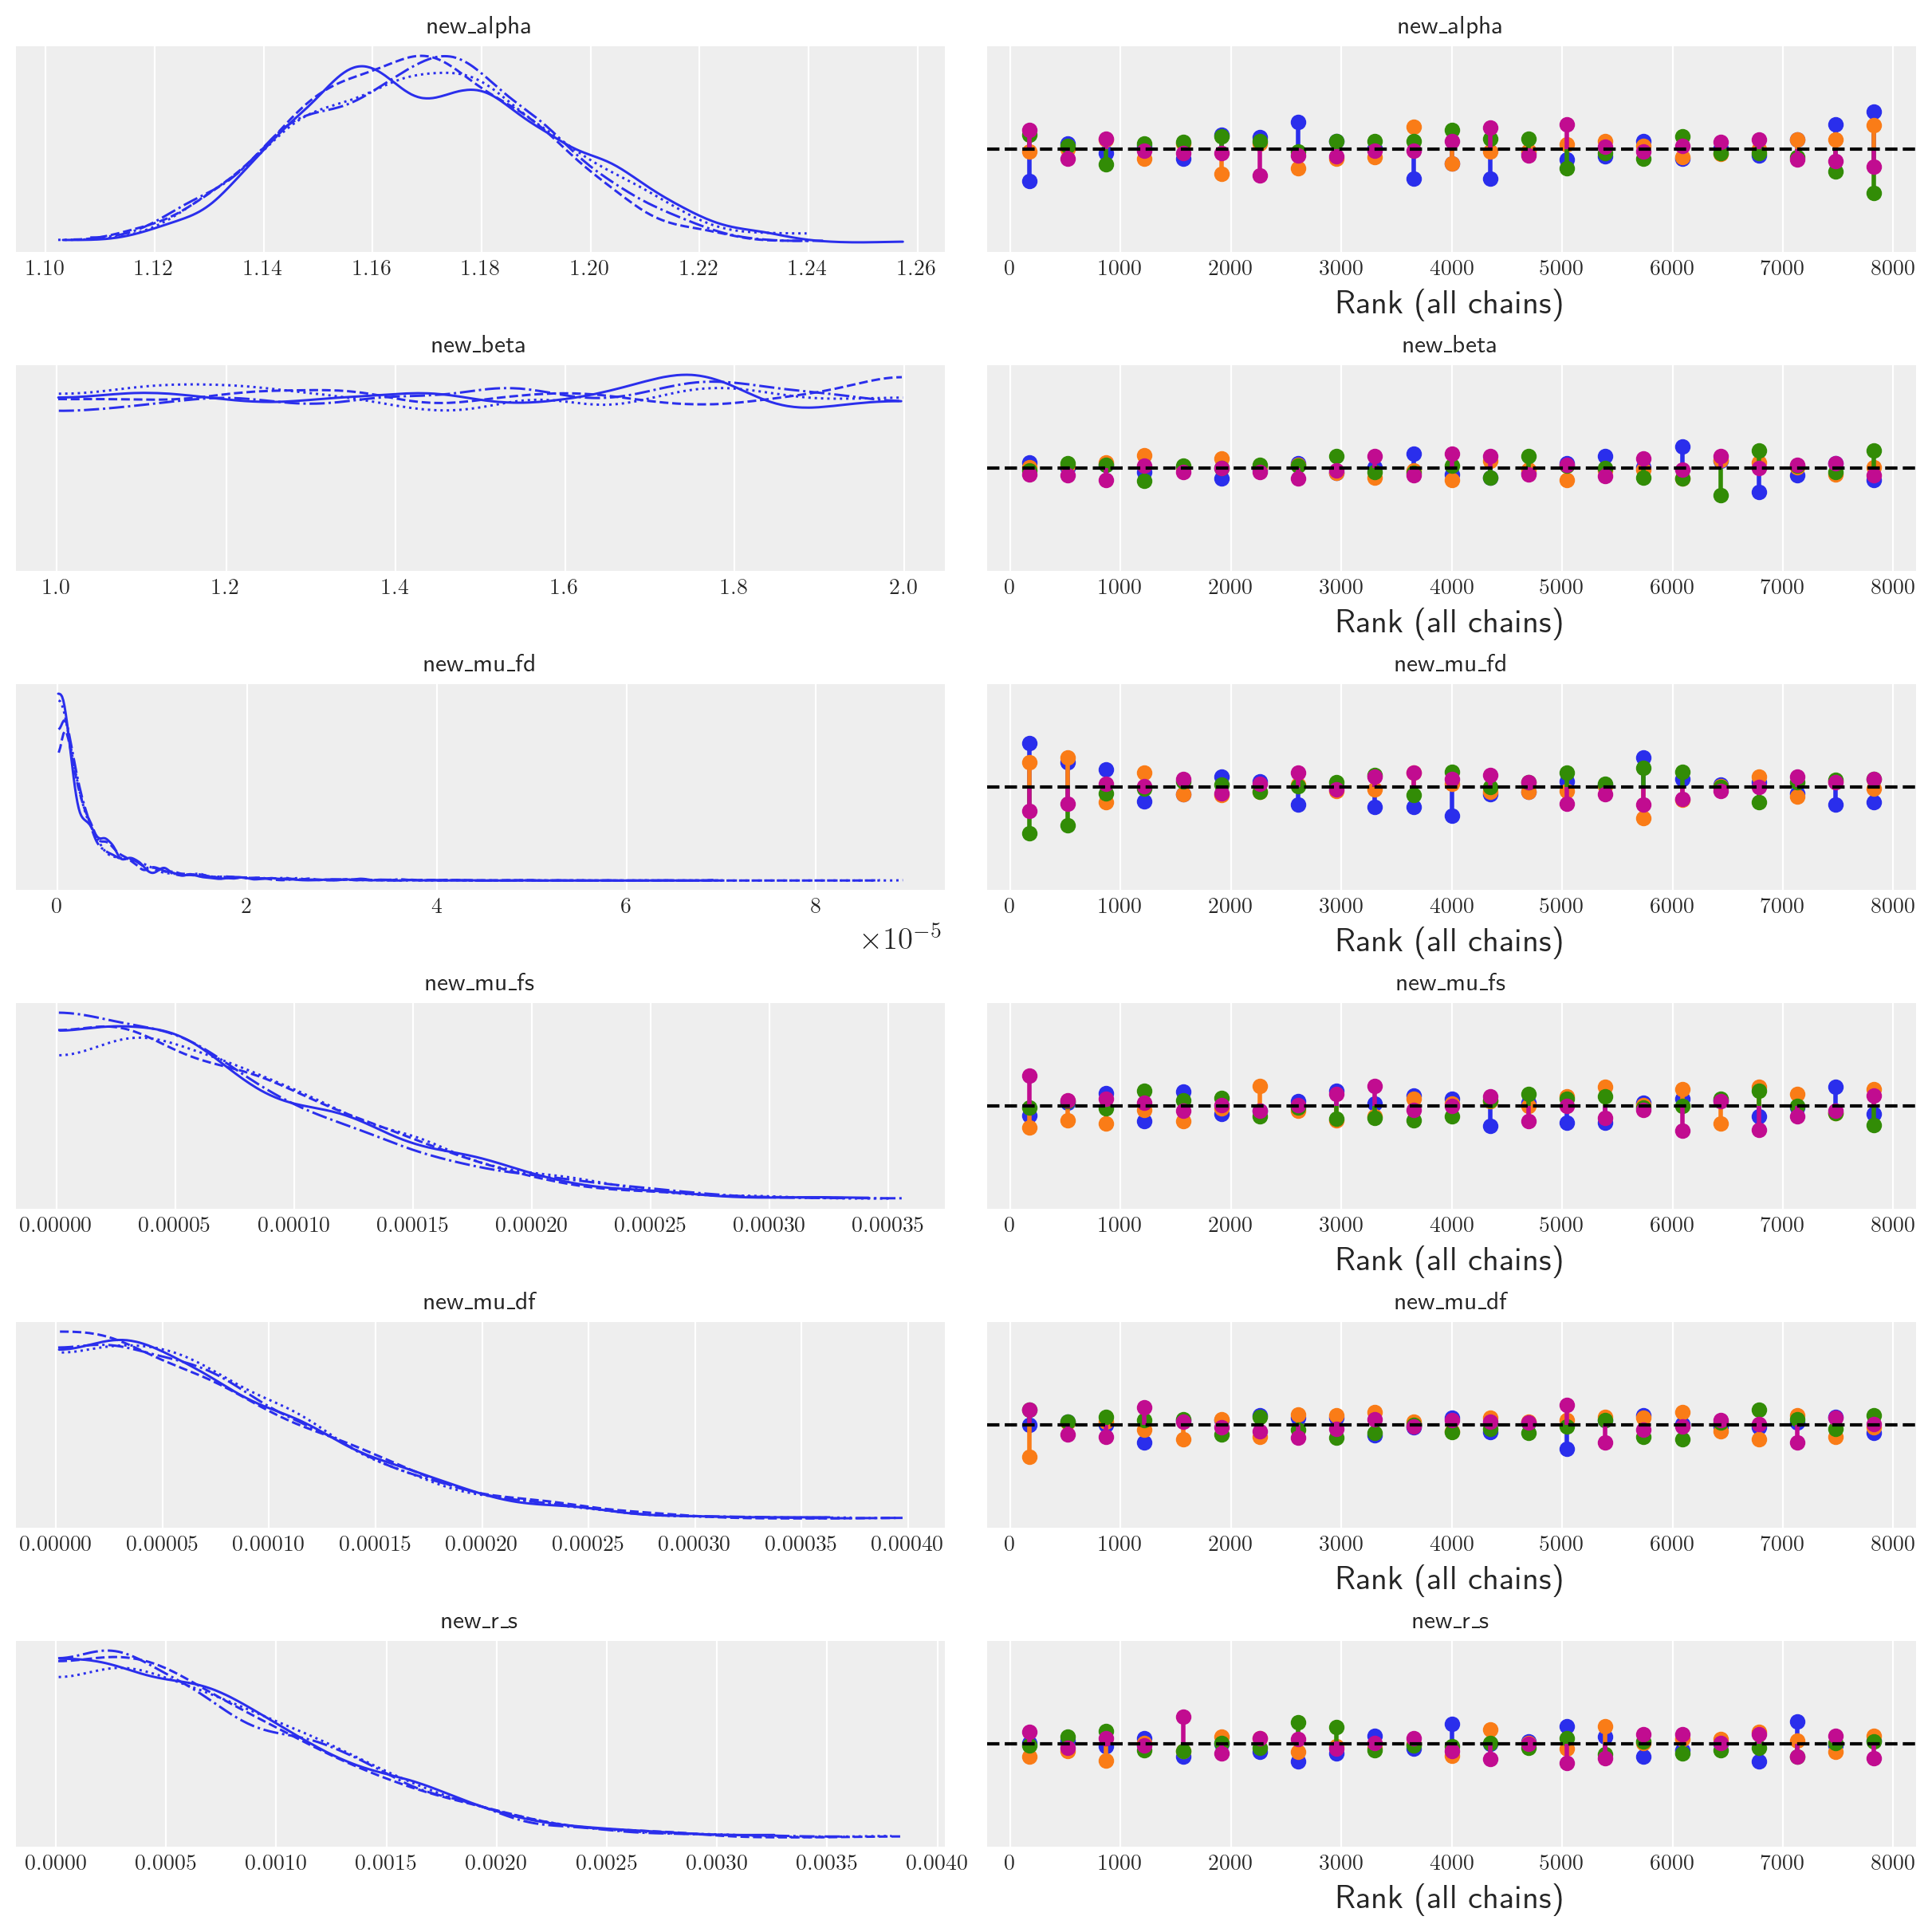

In [228]:
az.plot_trace(abc_data, kind="rank_vlines");

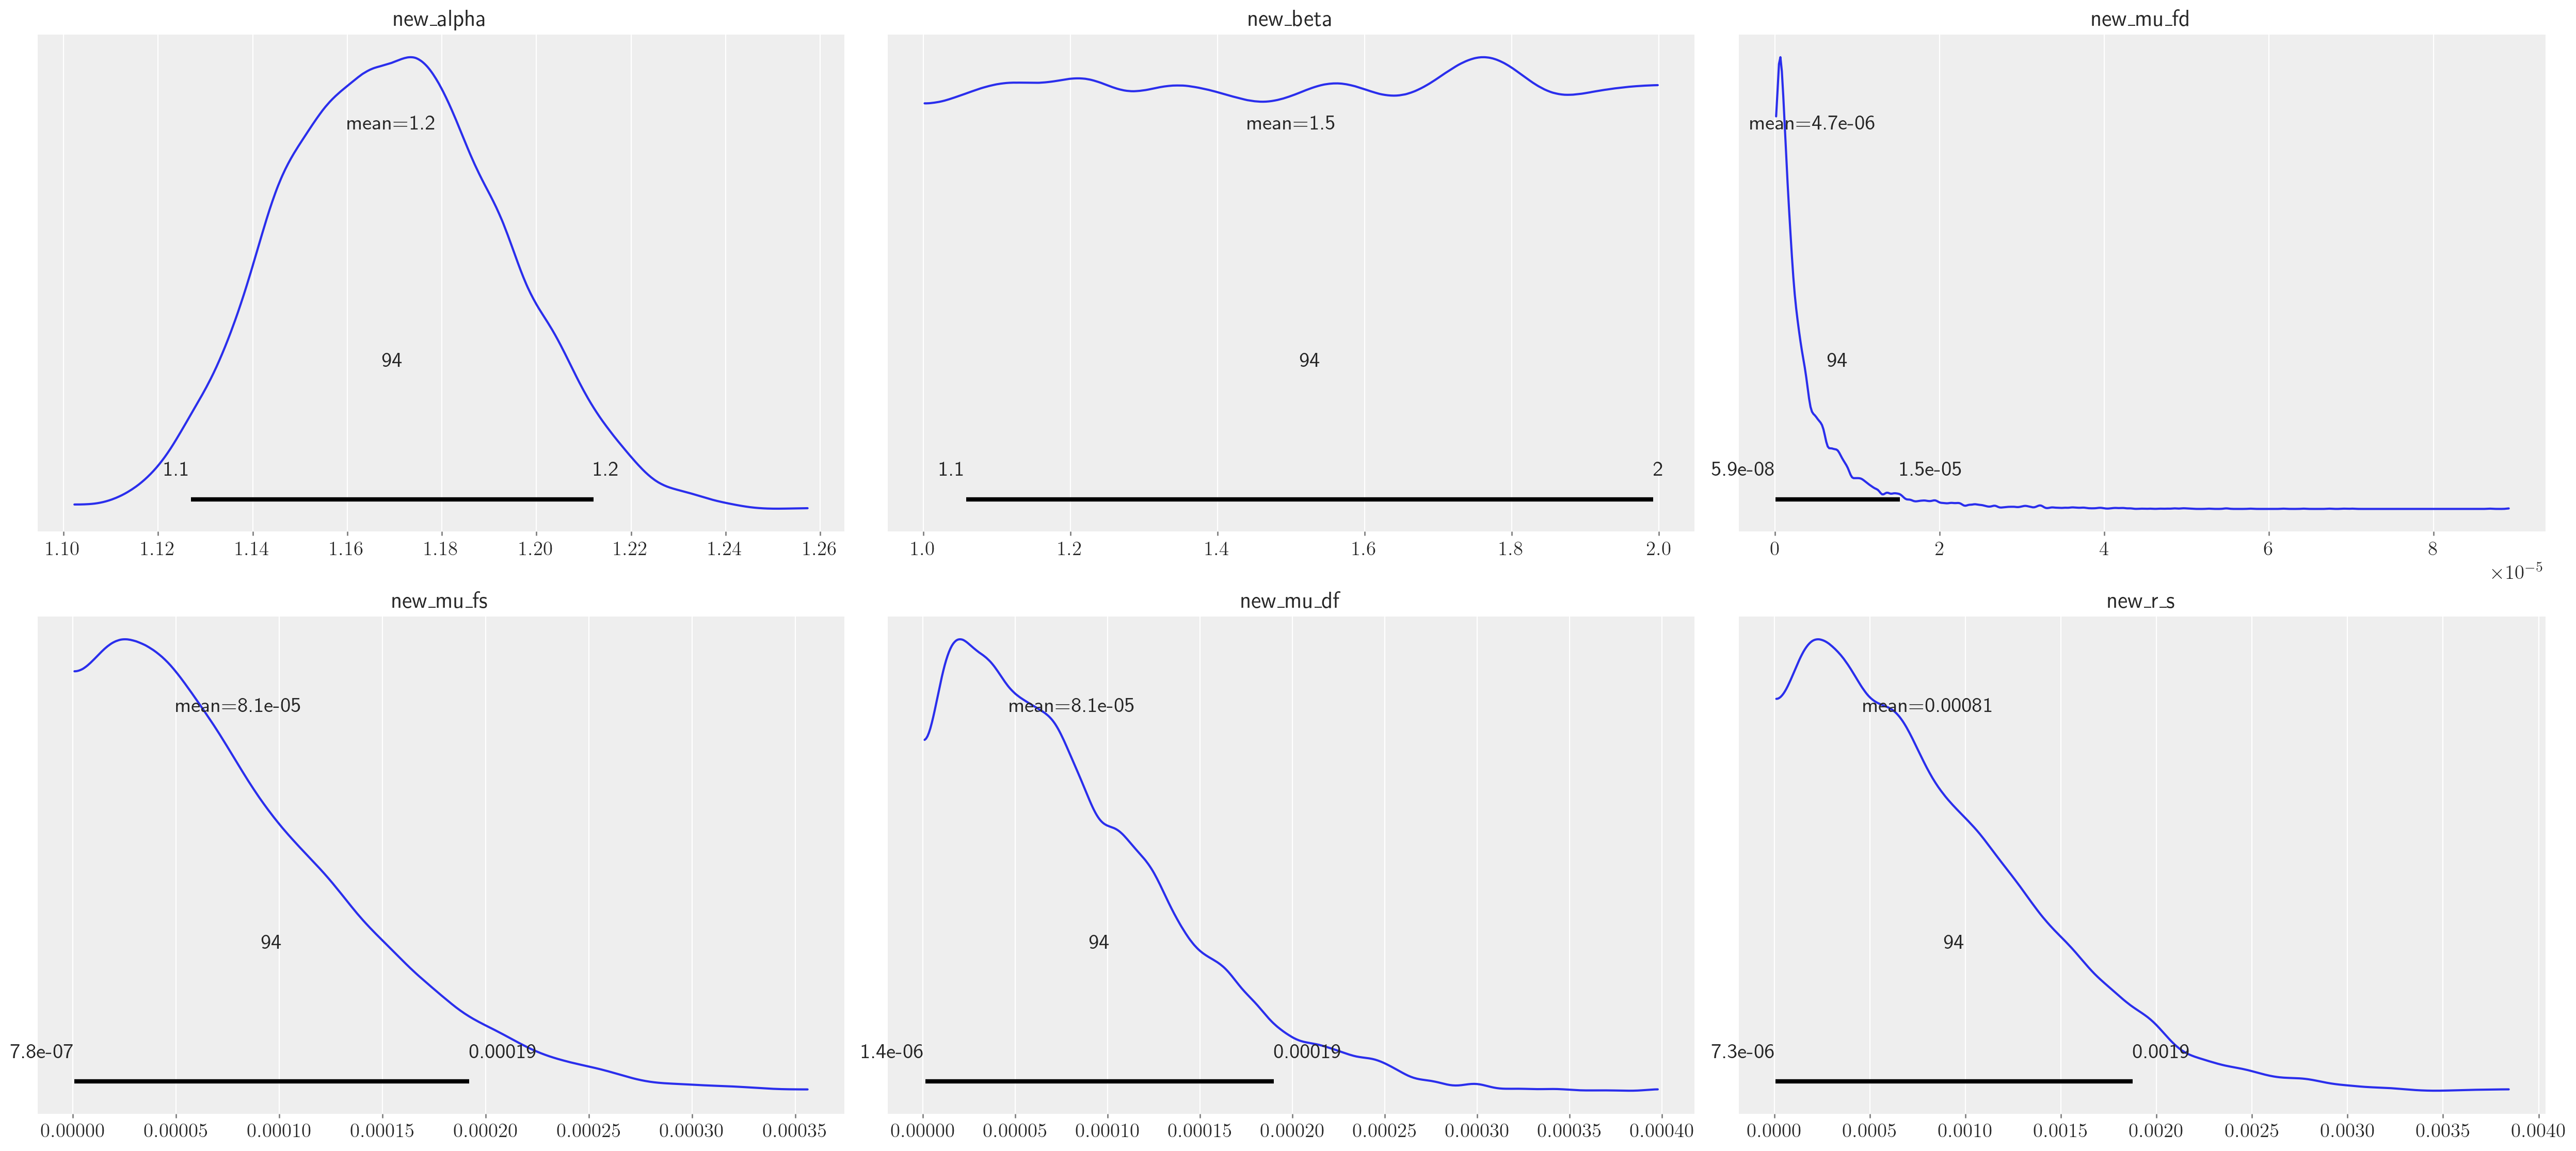

In [229]:
az.plot_posterior(abc_data);

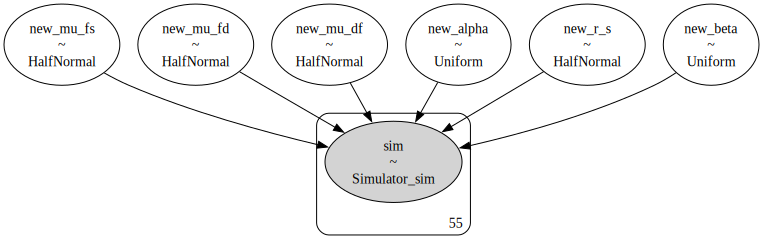

In [232]:
pm.model_to_graphviz(model)

In [272]:
# Read experimental data for inference
df = pd.read_csv('/Users/miguel/Documents/Internship_CENTURI/data/plate_counts.csv')
df = df.sort_values(['founder', 'replicate']).reset_index(drop=True)
temp_df = df[(df.founder=='delserCGA') & (df.replicate == 1)]

x = temp_df.day.values
y = temp_df[['frac_small']].values
x = temp_df.day.values
y = temp_df[['frac_small']].values

test_p0 = np.array([0.001, 0, 0])
num_days = 101
# When using delserCGA the replication rate of the founder is found using the growth curve fits
# Additionally, the replication rate of the mutant is assumed to be the rate of M2lop obtained with the gc fit
# The number of days in the experiment is 100, for testing let's assume 10
# M2lop replication rate : 0.05447838370459147
# delserCGA replication rate : 0.04060341705556068
# SNP Mutations per generation for wild type (https://doi.org/10.1093/gbe/evu284)
# 4.25e-9
# Using the same value for all as a proxy

updated_params = {'r_f' : 0.04060, 'r_d' : 0.05448, 'r_s' : 0.035, 'mu_fd' : 4.7e-6, 'mu_fs' : 8.1e-5, 'mu_df' : 8.1e-5, 'mu_sf' : 0.00081, 'K' : 1e2}
updated_model = EvolutionExperiment('delserCGA', num_days , updated_params, dilution_percentage= 1e-2)
updated_model.days_experiment = x
updated_model.p0 = test_p0
updated_model.alpha = 1.2
updated_model.beta = 1.5
#model_experiment.p1 = test_p0

In [273]:
updated_model.run_experiment()

Plot the evolution experiment results with the mean of the parameter distribution

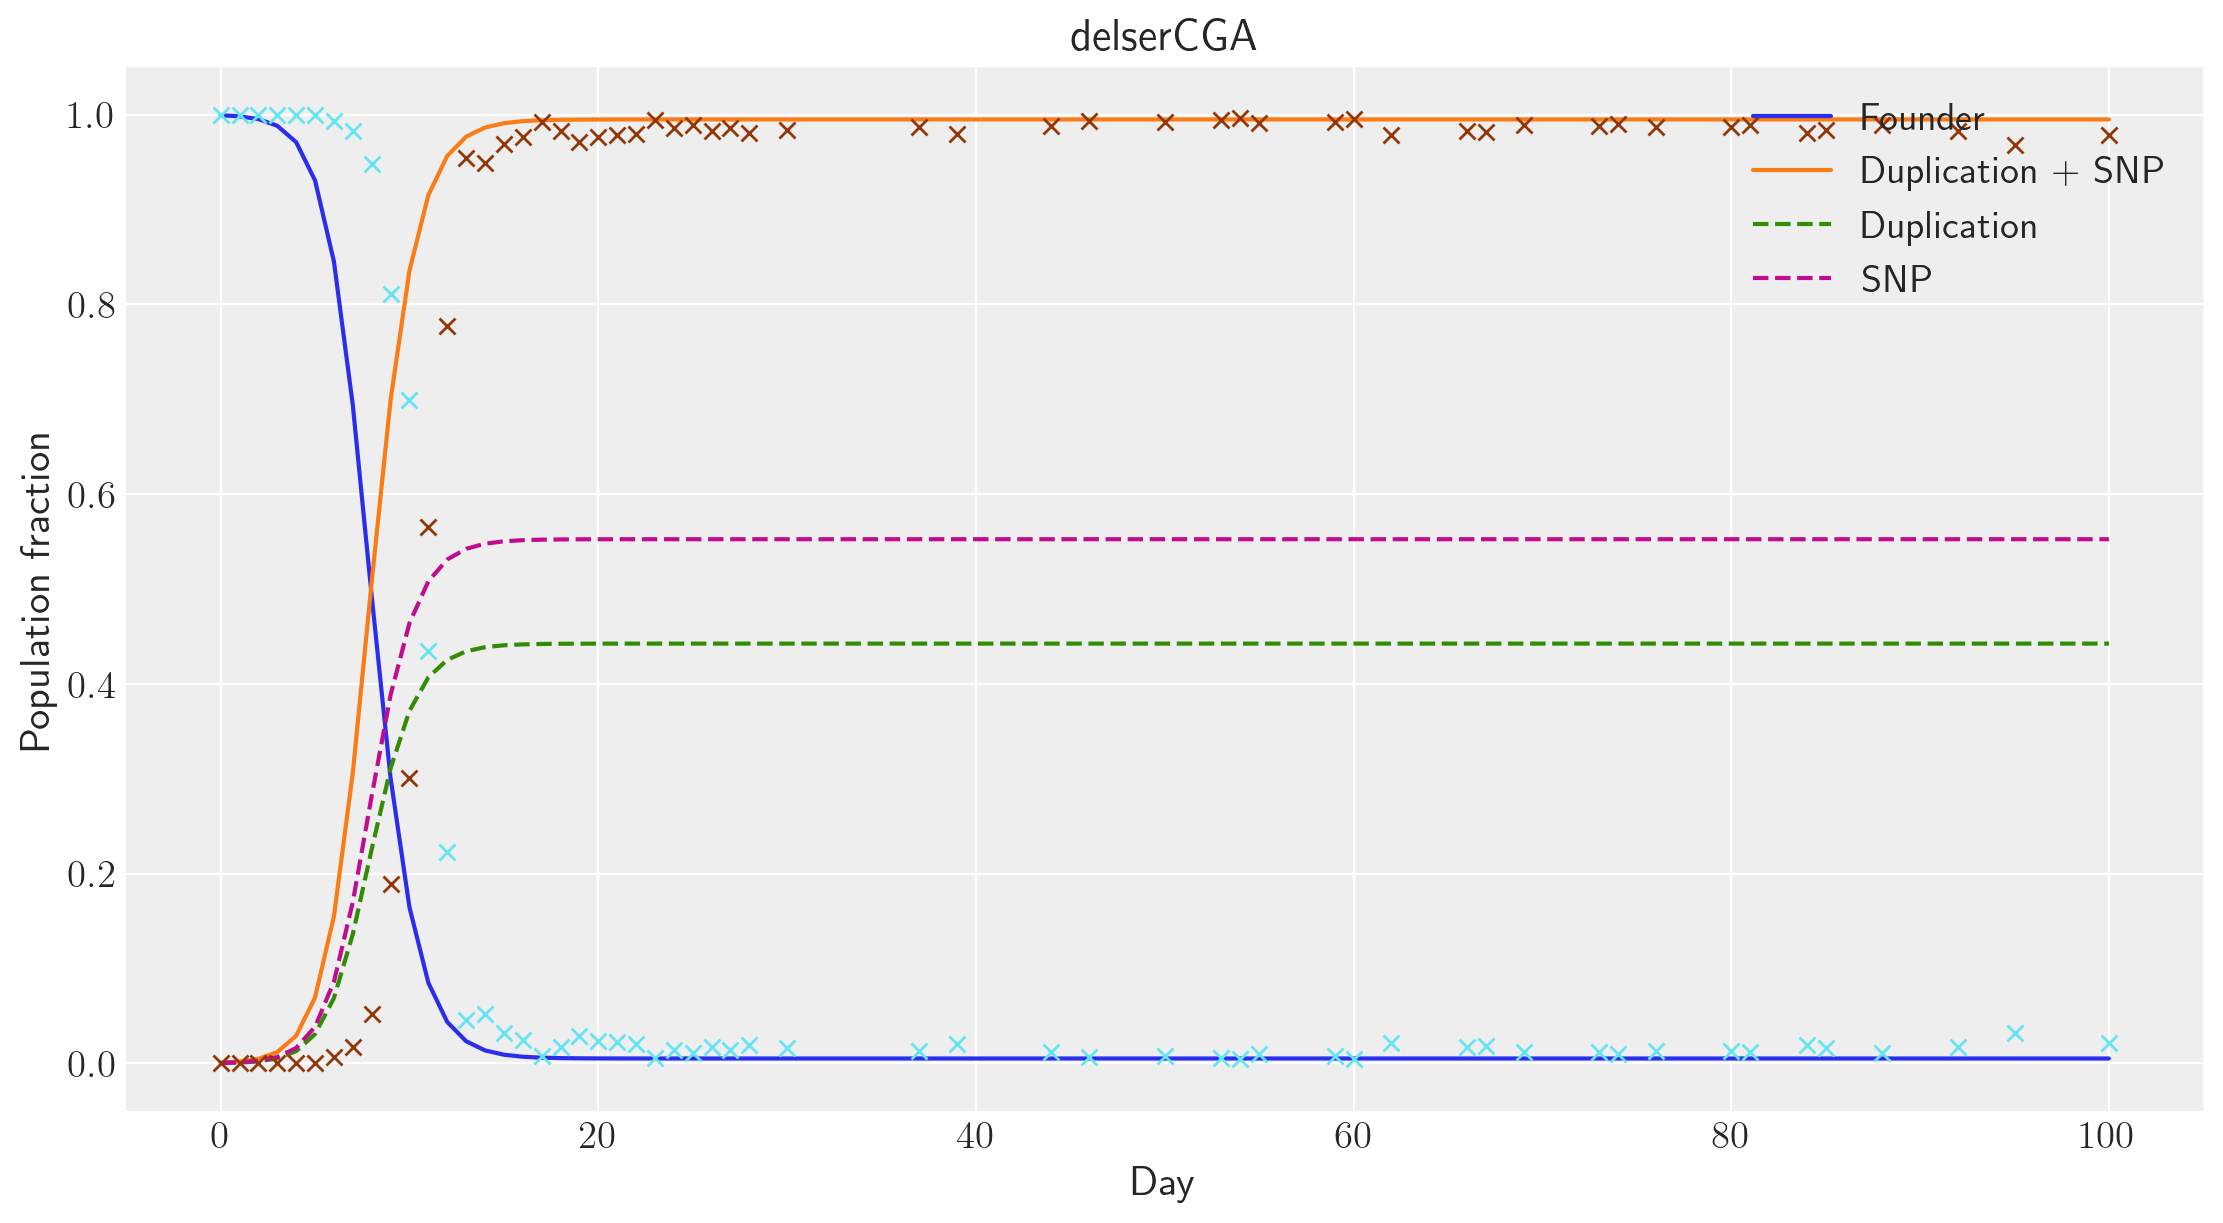

In [276]:
ax = updated_model.plot_evolution_frac()
ax.plot(temp_df.day.values , temp_df.frac_large, 'x', label = f'Replicate 1 large')
ax.plot(temp_df.day.values , temp_df.frac_small, 'x', label = f'Replicate 1 small')
plt.show()

In [280]:
with pm.Model() as kl_model:
    alpha = pm.Uniform("new_alpha", lower = 1, upper = 2)
    beta = pm.Uniform("new_beta", lower = 1, upper = 2)
    mu_fd = pm.HalfNormal("new_mu_fd", sigma = 1e-5)
    mu_fs = pm.HalfNormal("new_mu_fs", sigma = 1e-5)
    mu_df = pm.HalfNormal("new_mu_df", sigma = 1e-5)
    r_s = pm.HalfNormal("new_r_s", sigma = 1e-4)

    kl_sim = pm.Simulator("kl_sim", model_experiment.run_experiment_for_inference, params = (alpha, beta, mu_fd, mu_fs, mu_df,  r_s), epsilon = 0.01, observed = y.ravel(), distance = "laplace")

    kl_abc_data = pm.sample_smc(kernel="ABC")

/var/folders/j5/gzgbj85d7fl1z1qxpqp965kc0000gq/T/ipykernel_38229/519359717.py:11: FutureWarning: The kernel string argument "ABC" in sample_smc has been deprecated. It is no longer needed to distinguish between `abc` and `metropolis`
  kl_abc_data = pm.sample_smc(kernel="ABC")
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


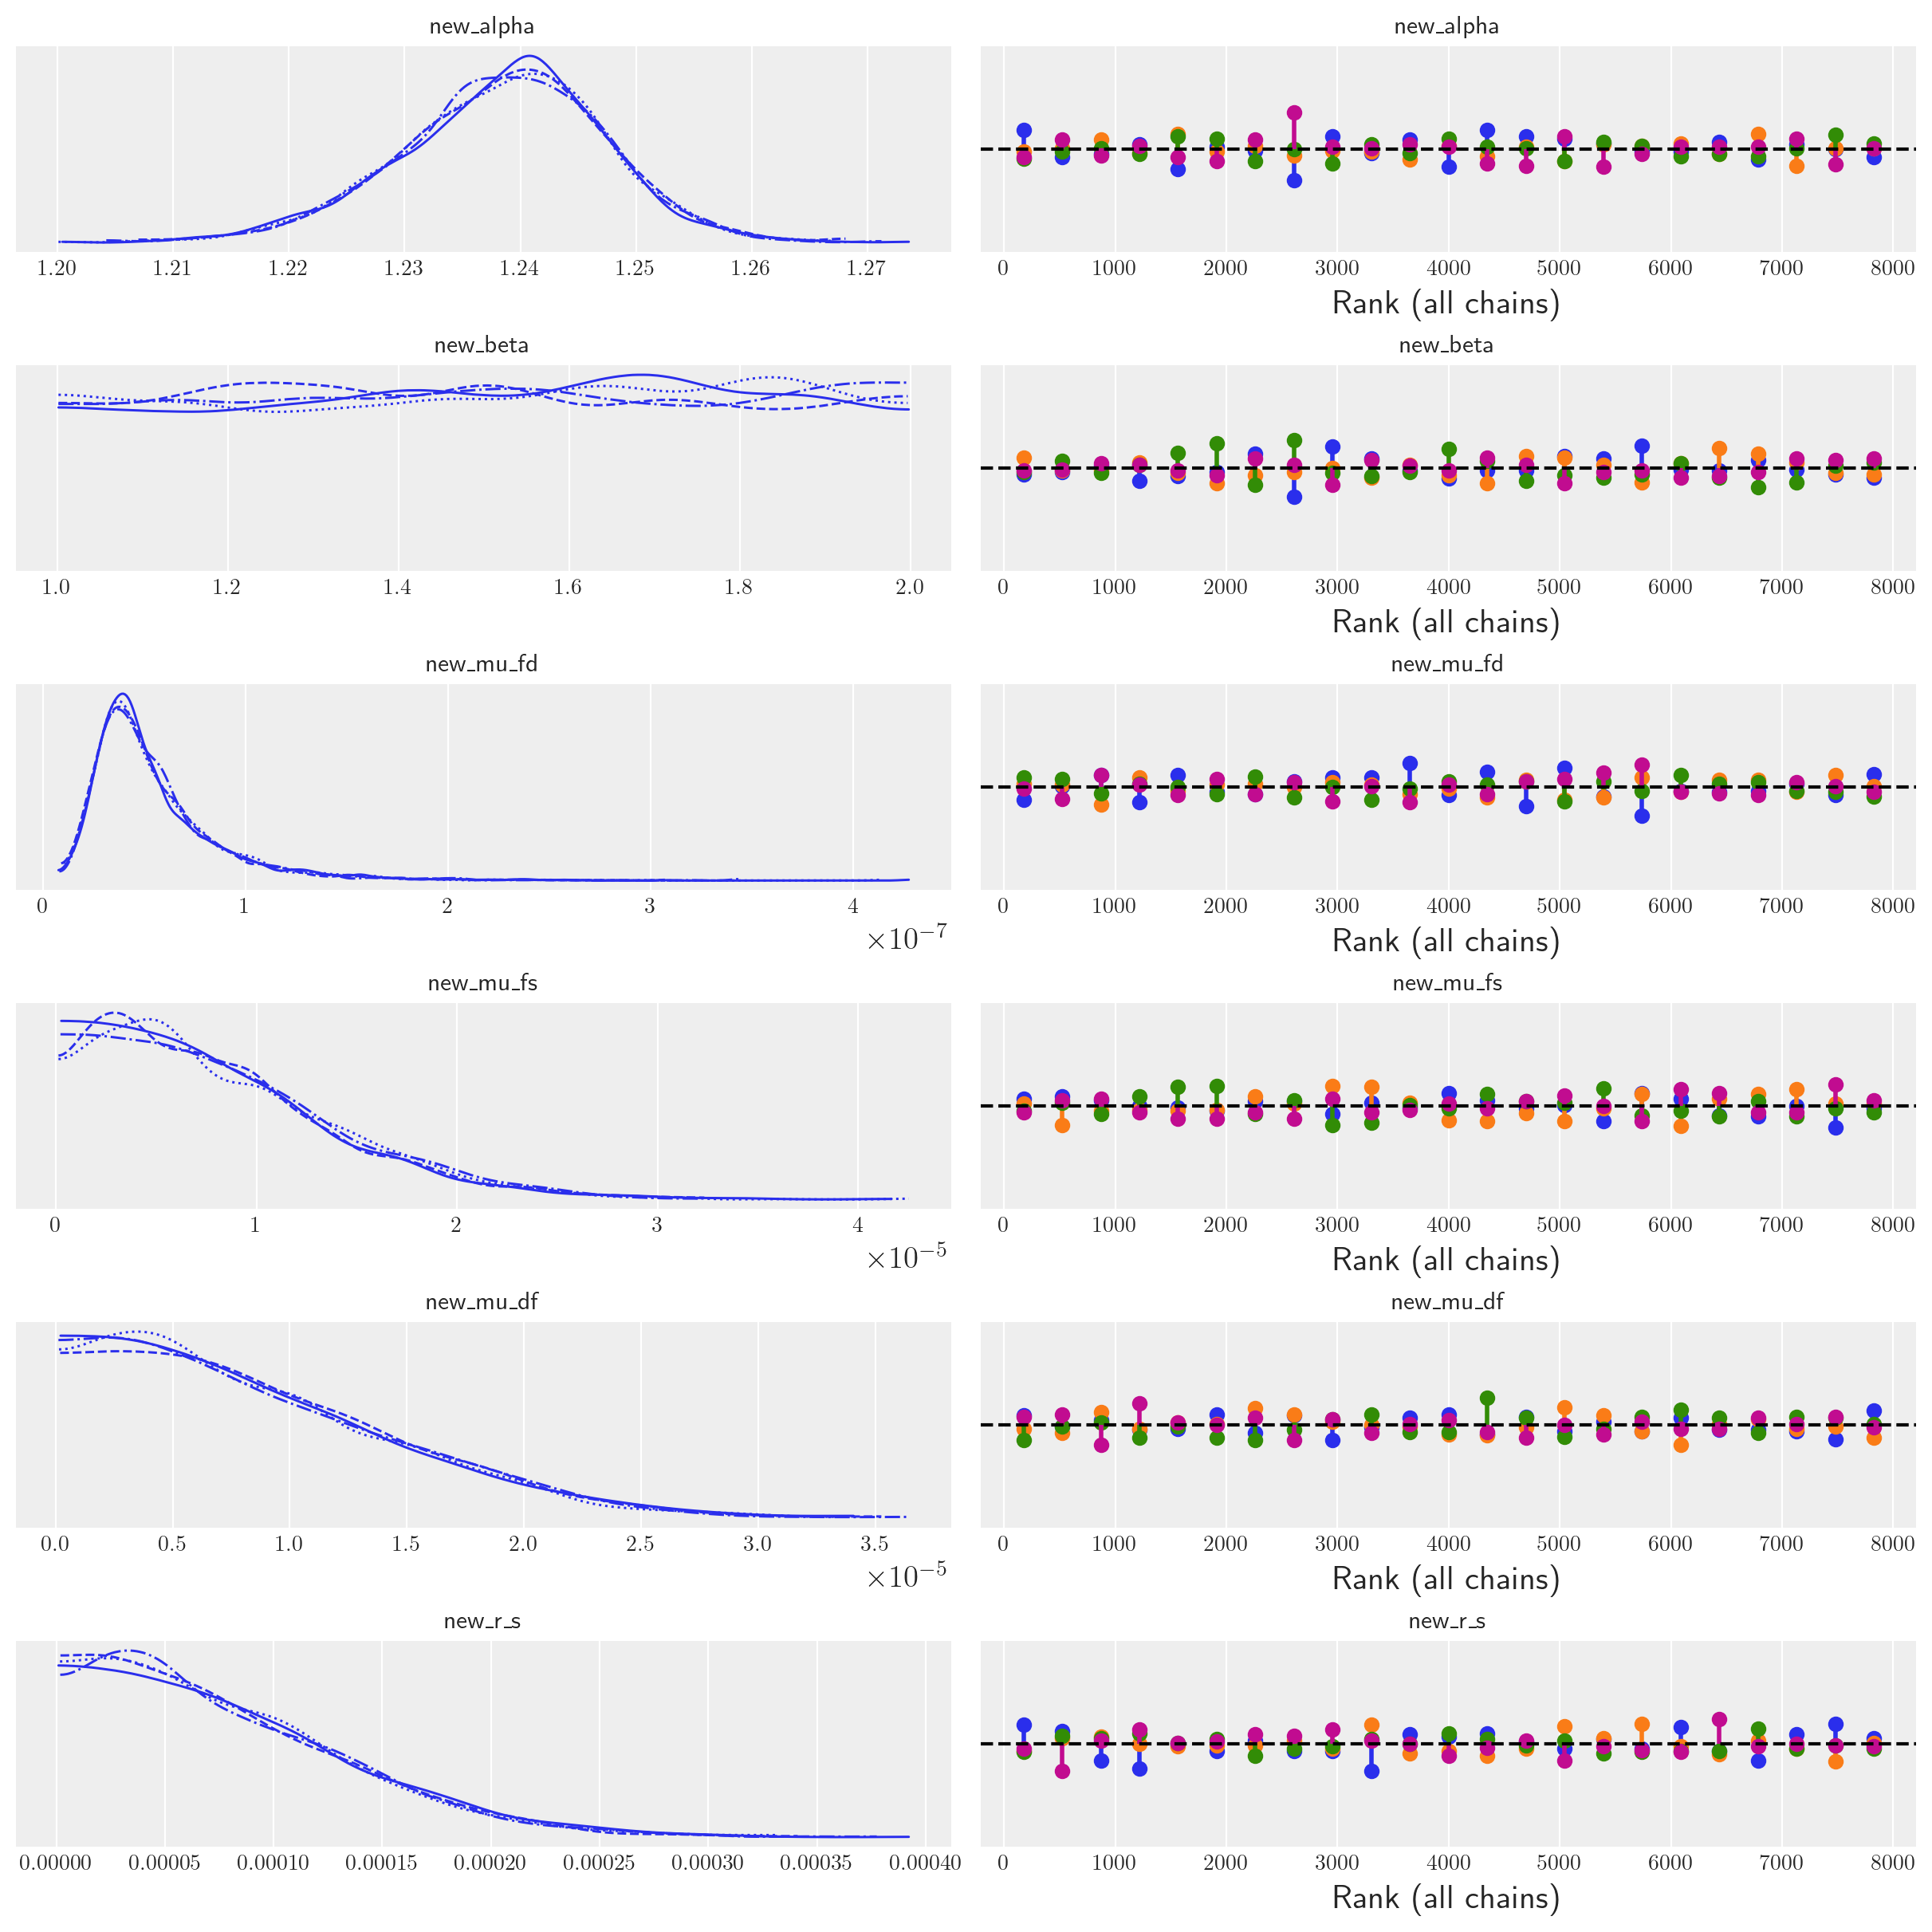

In [282]:
az.plot_trace(kl_abc_data, kind="rank_vlines");

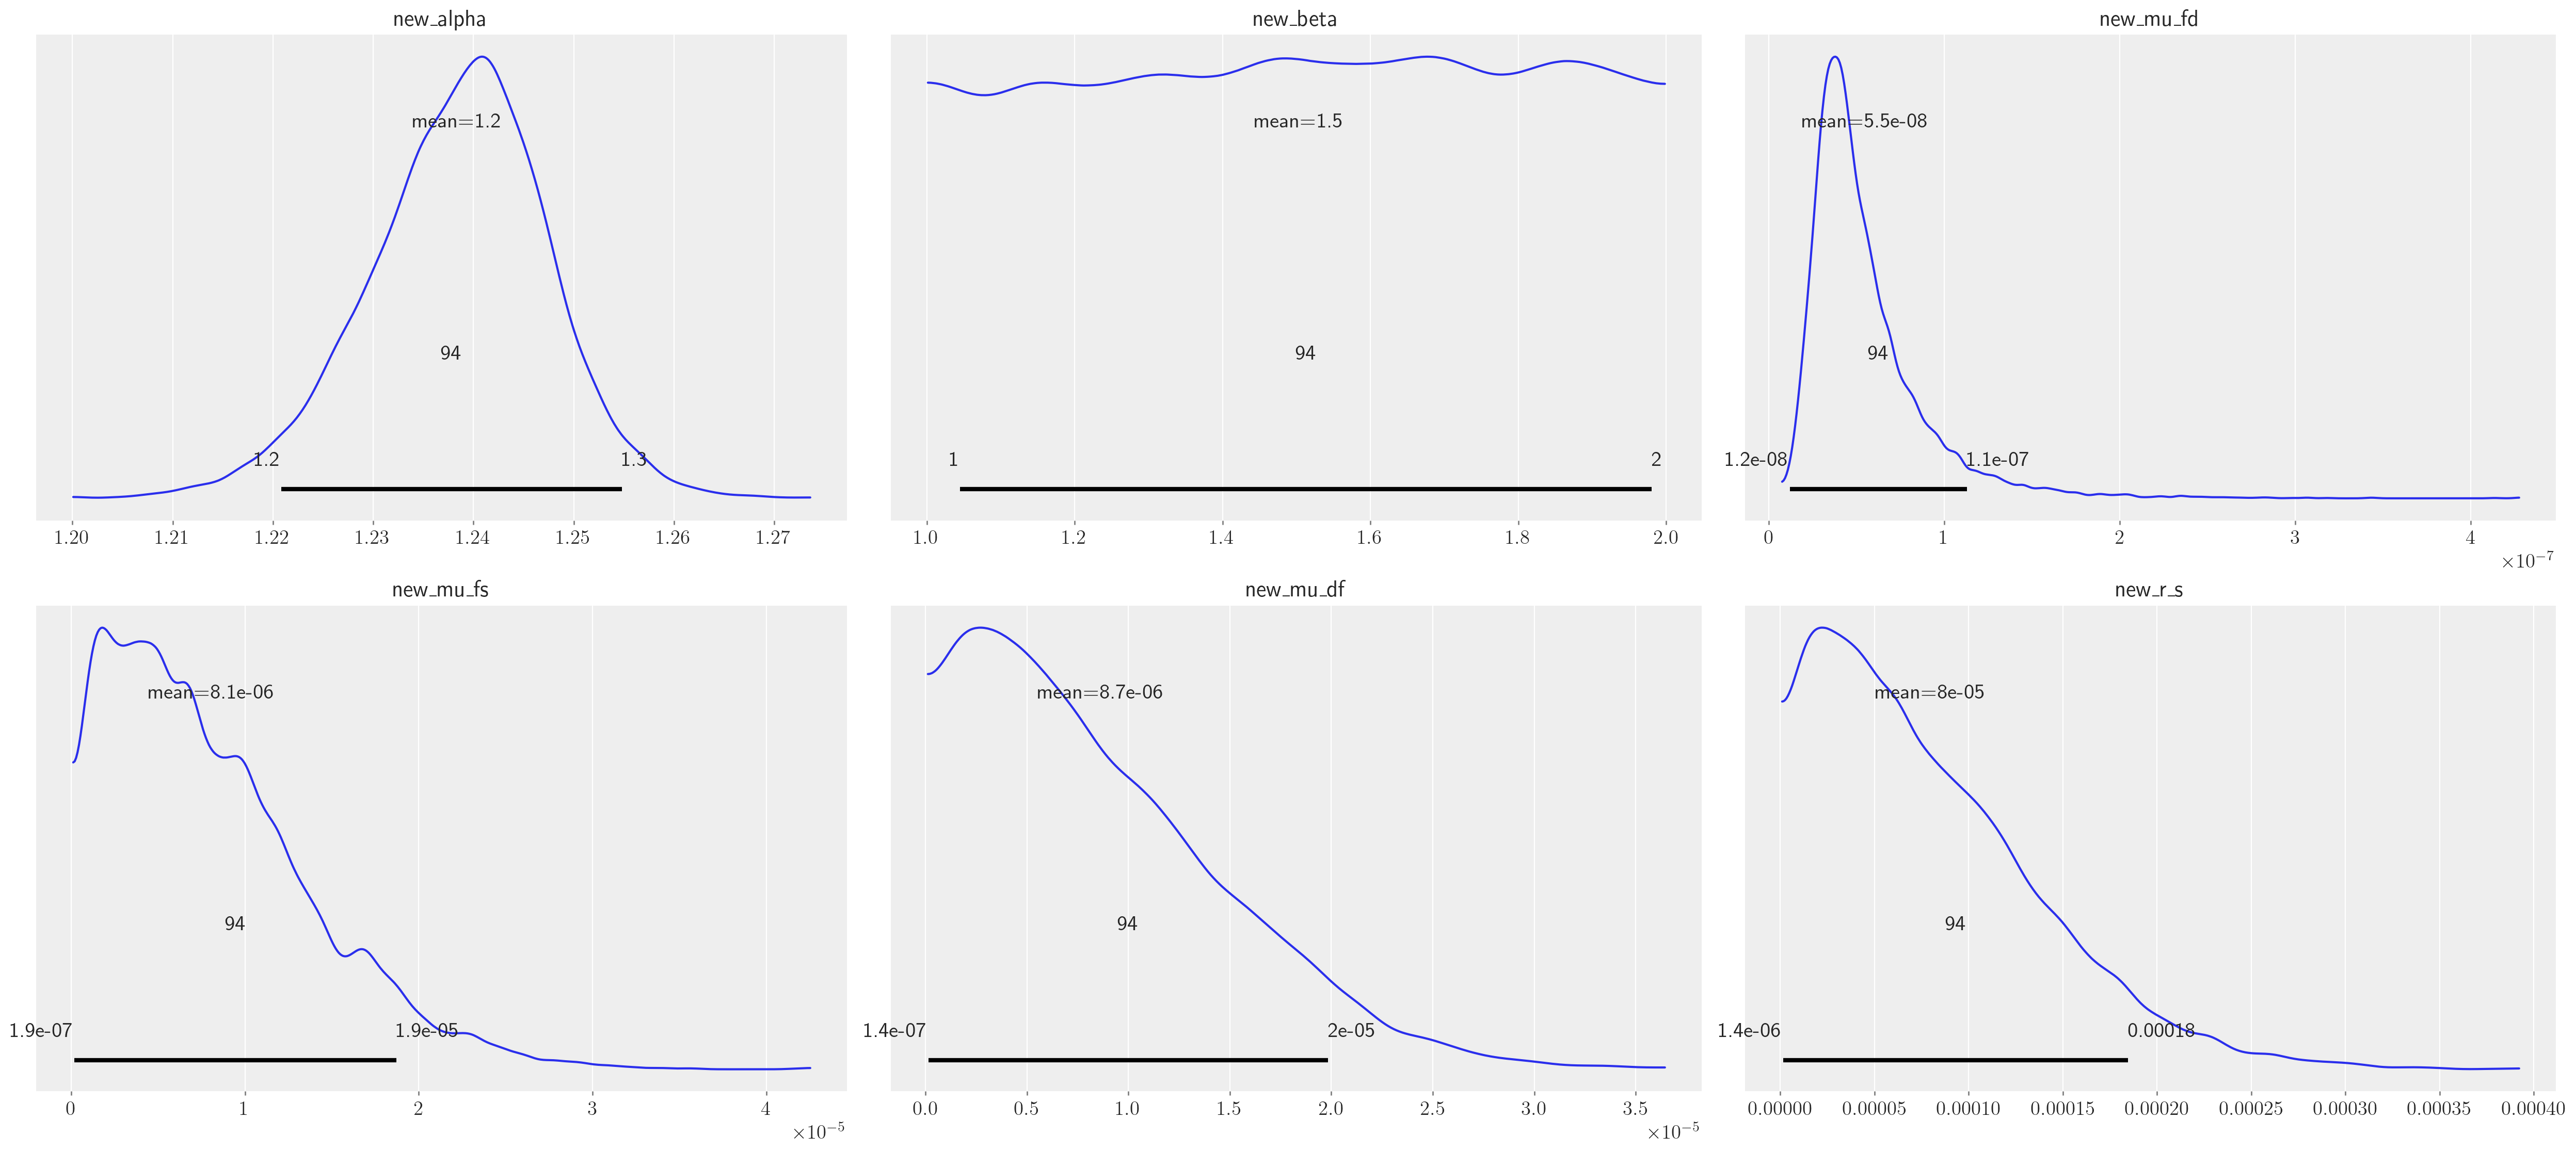

In [283]:
az.plot_posterior(kl_abc_data);

# Using the corrected initial conditions

In [284]:
# Read experimental data for inference
df = pd.read_csv('/Users/miguel/Documents/Internship_CENTURI/data/plate_counts.csv')
df = df.sort_values(['founder', 'replicate']).reset_index(drop=True)
temp_df = df[(df.founder=='delserCGA') & (df.replicate == 1)]

x = temp_df.day.values
y = temp_df[['frac_small']].values
x = temp_df.day.values
y = temp_df[['frac_small']].values

test_p0 = np.array([1, 0, 0])
num_days = 101
# When using delserCGA the replication rate of the founder is found using the growth curve fits
# Additionally, the replication rate of the mutant is assumed to be the rate of M2lop obtained with the gc fit
# The number of days in the experiment is 100, for testing let's assume 10
# M2lop replication rate : 0.05447838370459147
# delserCGA replication rate : 0.04060341705556068
# Mutations per generation for wild type (https://doi.org/10.1093/gbe/evu284)
# 4.25e-9
# Using the same value for all as a proxy

updated_params_2 = {'r_f' : 0.04060, 'r_d' : 0.05448, 'r_s' : 0.035, 'mu_fd' : 4.7e-6, 'mu_fs' : 8.1e-5, 'mu_df' : 8.1e-5, 'mu_sf' : 0.00081, 'K' : 1e2}
updated_model_2 = EvolutionExperiment('delserCGA', num_days , updated_params, dilution_percentage= 1e-2)
updated_model_2.days_experiment = x
updated_model_2.p0 = test_p0
updated_model_2.alpha = 1.2
updated_model_2.beta = 1.5
#model_experiment.p1 = test_p0

In [285]:
with pm.Model() as kl_model:
    alpha = pm.Uniform("new_alpha", lower = 1, upper = 2)
    beta = pm.Uniform("new_beta", lower = 1, upper = 2)
    mu_fd = pm.HalfNormal("new_mu_fd", sigma = 1e-5)
    mu_fs = pm.HalfNormal("new_mu_fs", sigma = 1e-5)
    mu_df = pm.HalfNormal("new_mu_df", sigma = 1e-5)
    r_s = pm.HalfNormal("new_r_s", sigma = 1e-4)

    updated_sim_2 = pm.Simulator("updated_sim_2", updated_model_2.run_experiment_for_inference, params = (alpha, beta, mu_fd, mu_fs, mu_df, r_s), epsilon = 0.001, observed = y.ravel(), distance = "laplace")

    updated_sim_2_abc_data = pm.sample_smc(chains = 8)

Initializing SMC sampler...
Sampling 8 chains in 4 jobs


 |████████████████████████████████████████| 100.00% [100/100 00:00<?  Stage: 11 Beta: 1.000]   

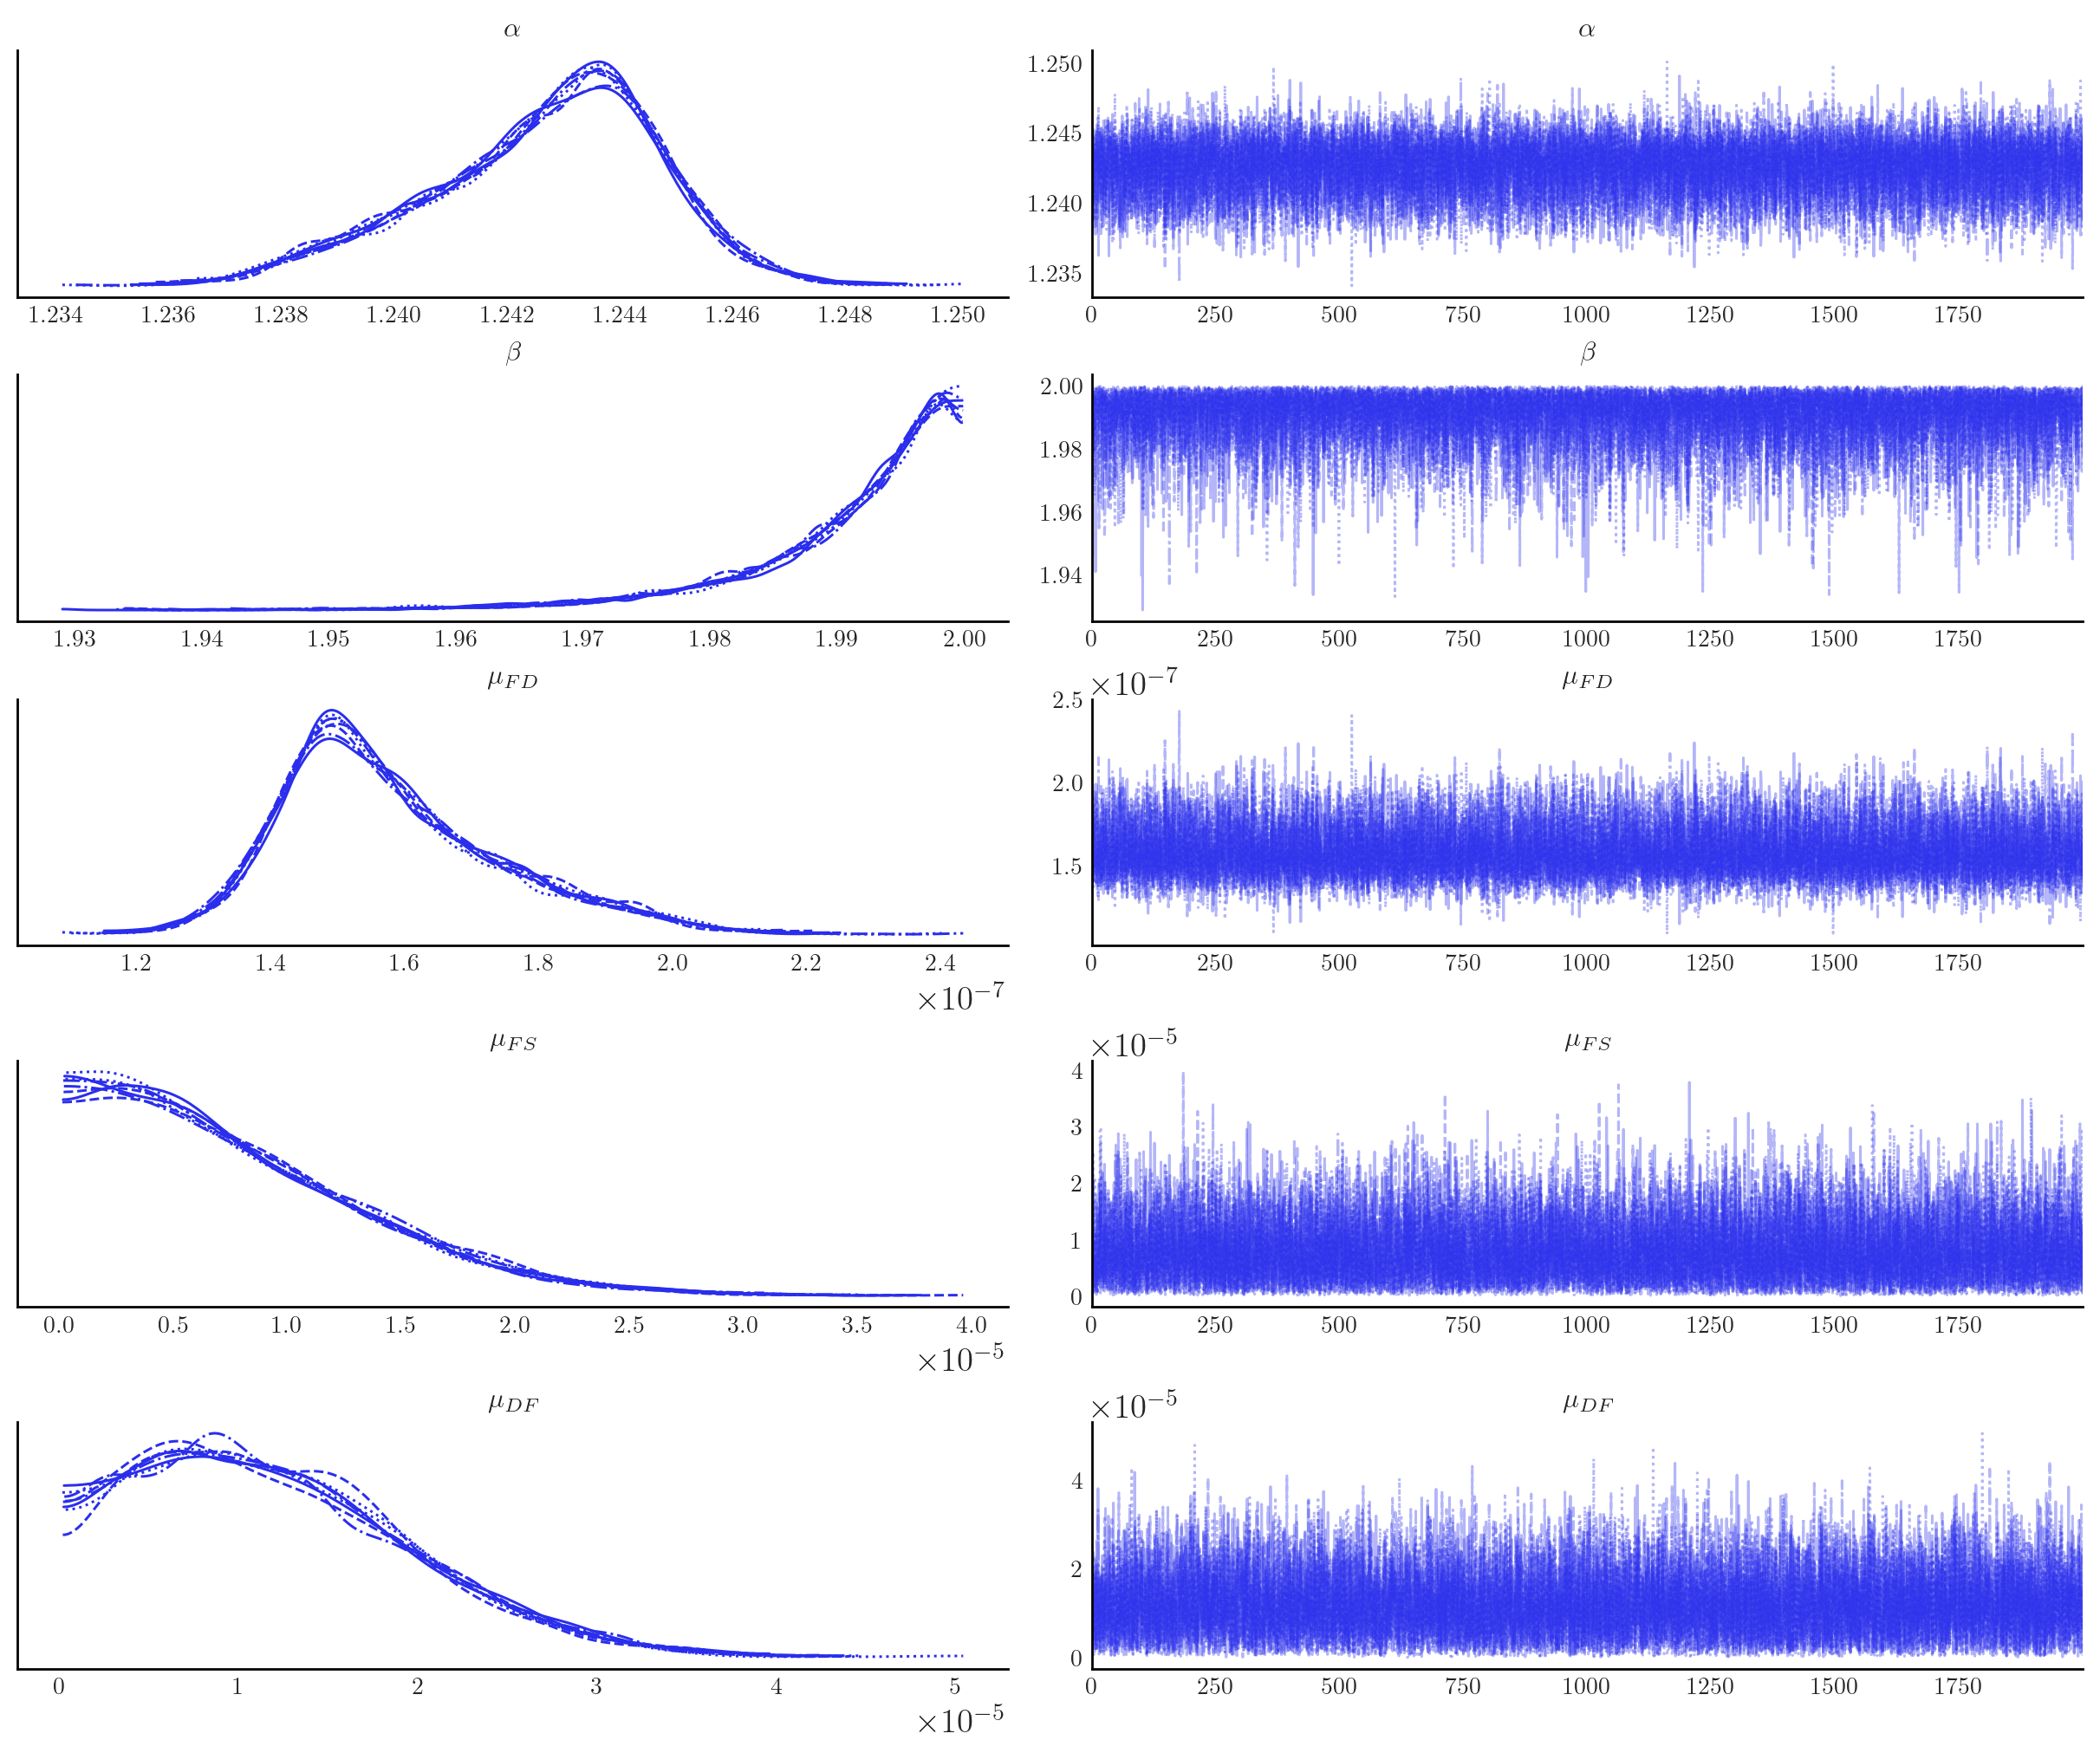

In [328]:
labeller = azl.MapLabeller(var_name_map={"new_alpha": r"$\alpha$", 'new_beta': r"$\beta$", 'new_mu_fd': r"$\mu_{FD}$", 'new_mu_fs': r"$\mu_{FS}$", 'new_mu_df': r"$\mu_{DF}$", 'new_r_s': r"$r_S$"})
az.plot_trace(updated_sim_2_abc_data, labeller = labeller, var_names = ['new_alpha', 'new_beta', 'new_mu_fd', 'new_mu_fs', 'new_mu_df', '~new_r_s']);
fig = plt.gcf();
fig.savefig(CWD + '/plots/abc_3st_param_dist.png', dpi = 300);

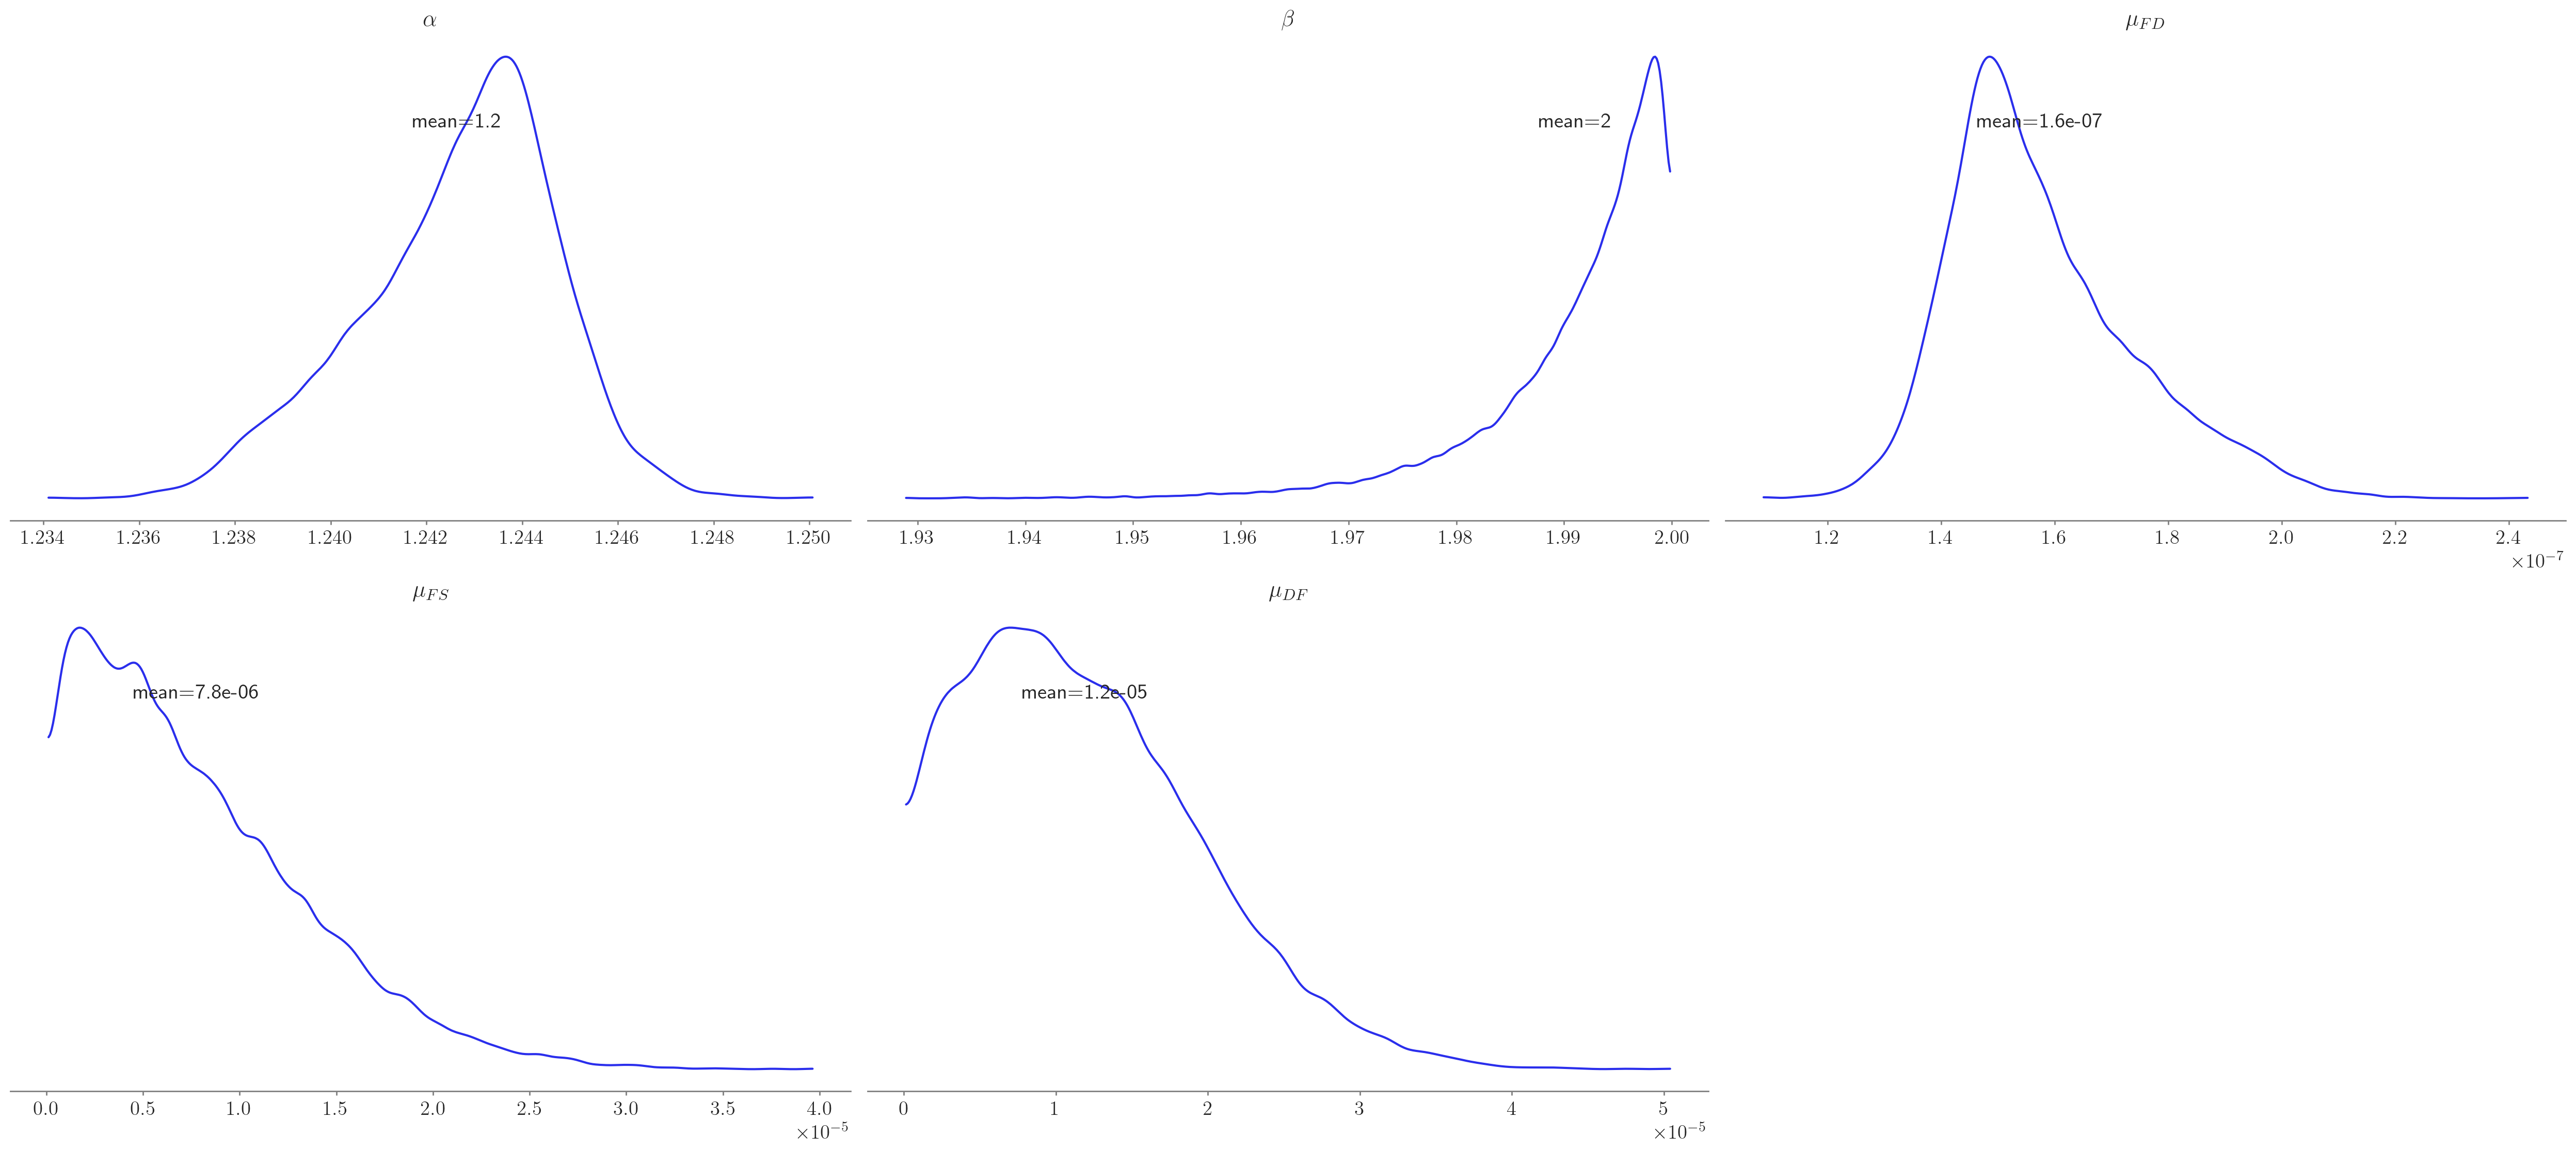

In [335]:
import arviz.labels as azl
labeller = azl.MapLabeller(var_name_map={"new_alpha": r"$\alpha$", 'new_beta': r"$\beta$", 'new_mu_fd': r"$\mu_{FD}$", 'new_mu_fs': r"$\mu_{FS}$", 'new_mu_df': r"$\mu_{DF}$", 'new_r_s': r"$r_S$"})
az.plot_posterior(updated_sim_2_abc_data, var_names = ['new_alpha', 'new_beta', 'new_mu_fd', 'new_mu_fs', 'new_mu_df', '~new_r_s'], point_estimate = 'mean', labeller = labeller, hdi_prob = 'hide');
fig = plt.gcf();
fig.savefig(CWD + '/plots/abc_3st_posterior.png', dpi = 300);

In [345]:
az.summary(updated_sim_2_abc_data, kind="stats", round_to = "none")

mean            sd        hdi_3%       hdi_97%
new_alpha  1.242660e+00  2.047662e-03  1.238349e+00  1.245992e+00
new_beta   1.991100e+00  8.490153e-03  1.975458e+00  1.999879e+00
new_mu_fd  1.575858e-07  1.634038e-08  1.319742e-07  1.924920e-07
new_mu_fs  7.810981e-06  5.804835e-06  1.721464e-07  1.831876e-05
new_mu_df  1.199410e-05  7.597790e-06  3.071870e-07  2.523055e-05
new_r_s    8.039323e-05  5.960879e-05  8.995901e-07  1.864877e-04

In [337]:
with pm.Model() as kl_model:
    updated_sim_2_abc_data.extend(pm.sample_posterior_predictive(updated_sim_2_abc_data))

In [339]:
az.plot_ppc(updated_sim_2_abc_data, num_pp_samples=500);

TypeError: `data` argument must have the group "posterior_predictive" for ppcplot

In [292]:
# Read experimental data for inference
df = pd.read_csv('/Users/miguel/Documents/Internship_CENTURI/data/plate_counts.csv')
df = df.sort_values(['founder', 'replicate']).reset_index(drop=True)
temp_df = df[(df.founder=='delserCGA') & (df.replicate == 1)]

x = temp_df.day.values
y = temp_df[['frac_small']].values
x = temp_df.day.values
y = temp_df[['frac_small']].values

test_p0 = np.array([0.001, 0, 0])
num_days = 101
# When using delserCGA the replication rate of the founder is found using the growth curve fits
# Additionally, the replication rate of the mutant is assumed to be the rate of M2lop obtained with the gc fit
# The number of days in the experiment is 100, for testing let's assume 10
# M2lop replication rate : 0.05447838370459147
# delserCGA replication rate : 0.04060341705556068
# Mutations per generation for wild type (https://doi.org/10.1093/gbe/evu284)
# 4.25e-9
# Using the same value for all as a proxy

updated_params_3 = {'r_f' : 0.04060, 'r_d' : 0.05448, 'r_s' : 0.035, 'mu_fd' : 1.6e-7, 'mu_fs' : 7.8e-6, 'mu_df' : 1.2e-5, 'mu_sf' : 0.00081, 'K' : 1e2}
updated_model_3 = EvolutionExperiment('delserCGA', num_days , updated_params_3, dilution_percentage= 1e-2)
updated_model_3.days_experiment = x
updated_model_3.p0 = test_p0
updated_model_3.alpha = 1.2
updated_model_3.beta = 2
#model_experiment.p1 = test_p0

In [293]:
updated_model_3.run_experiment()

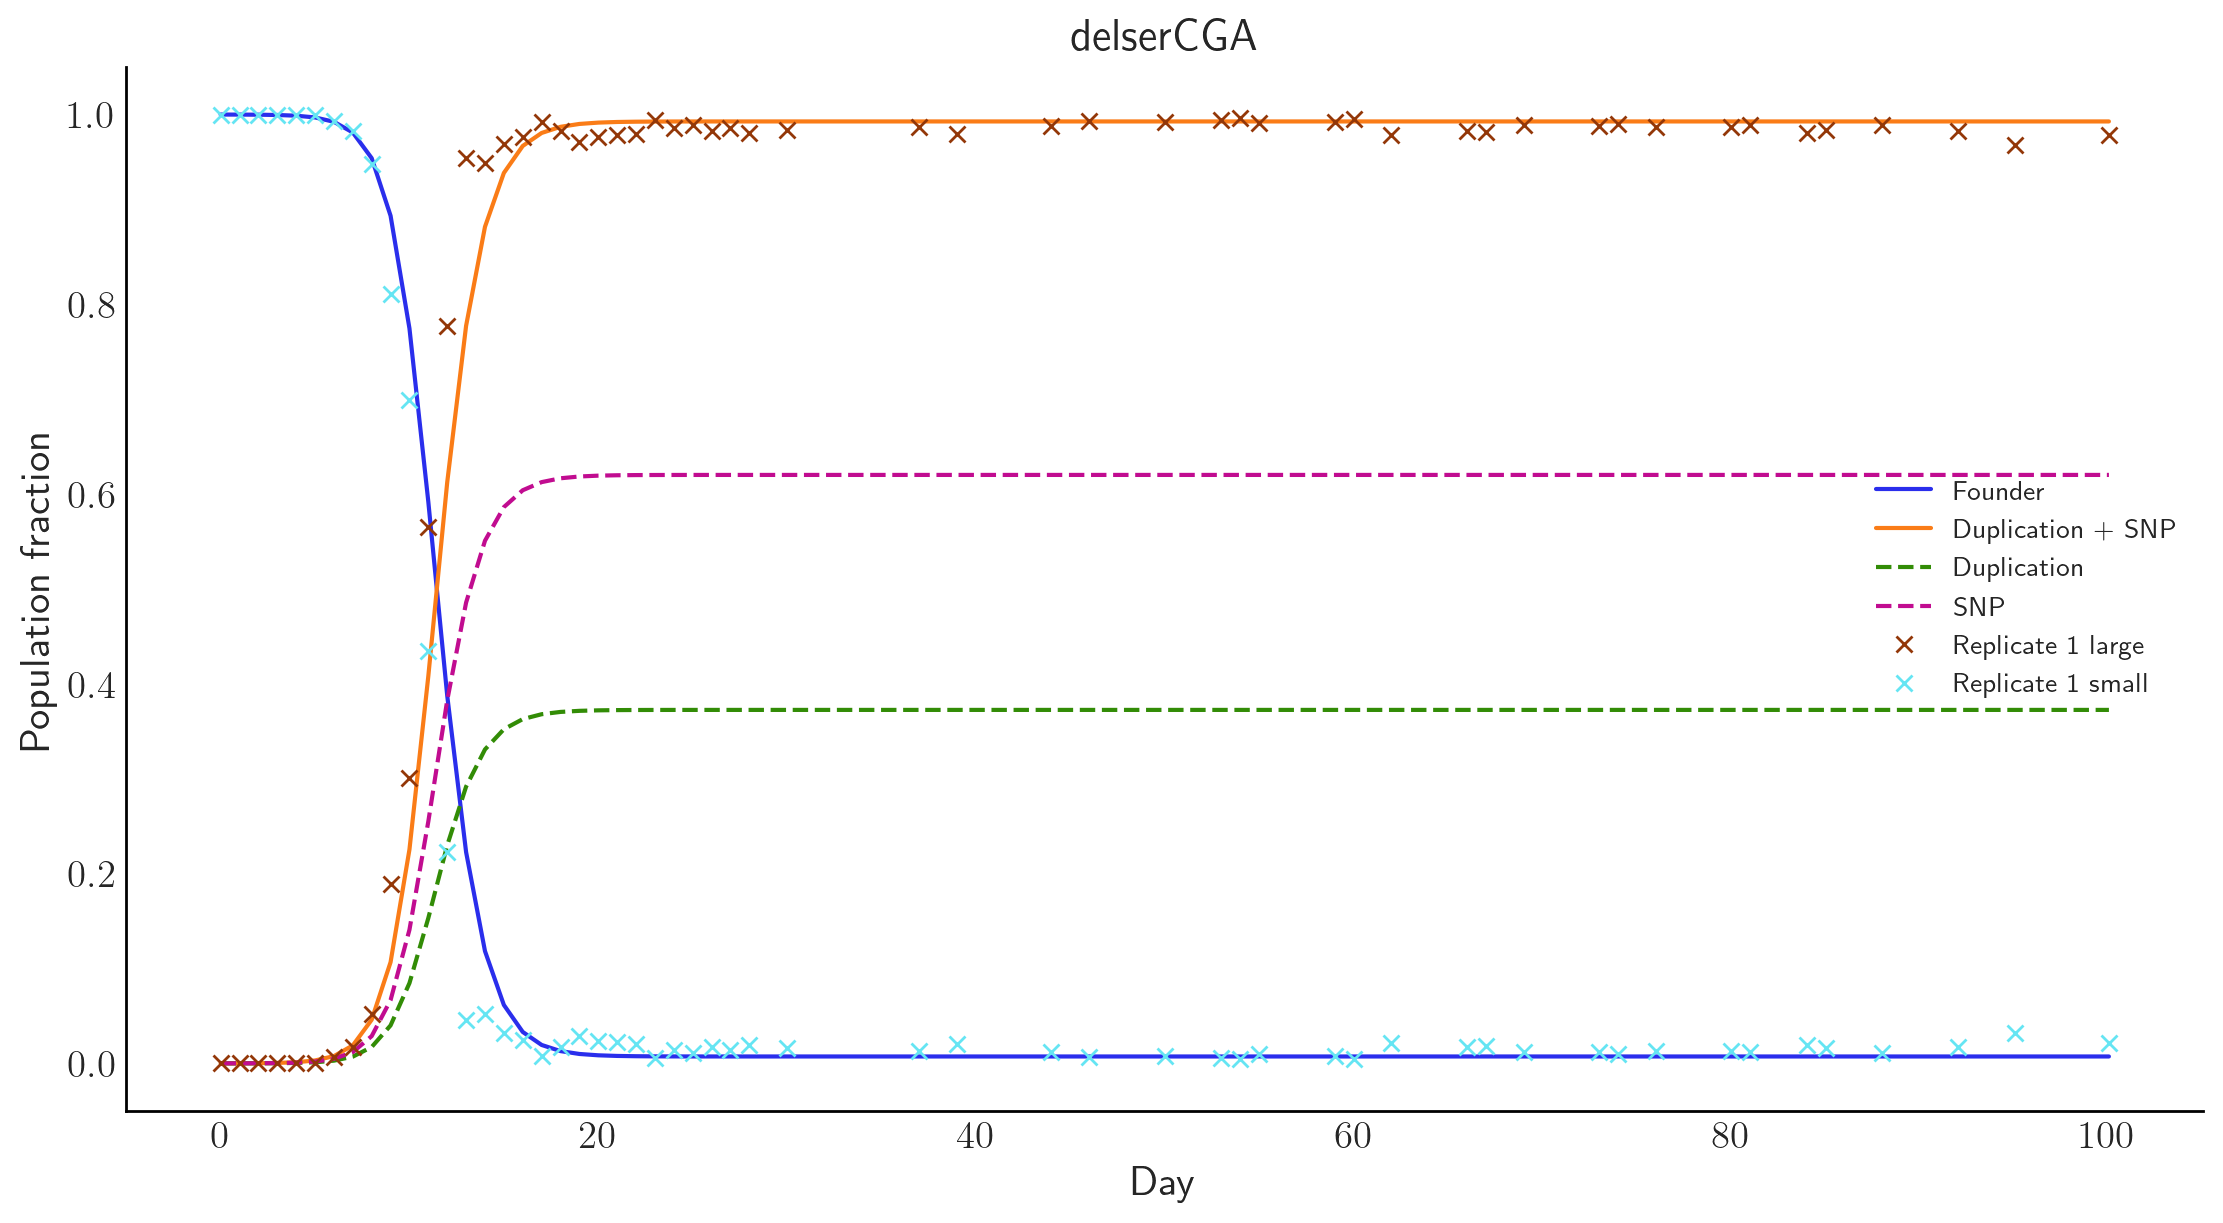

In [347]:
az.style.use("arviz-white")
ax = updated_model_3.plot_evolution_frac()
ax.plot(temp_df.day.values , temp_df.frac_large, 'x', label = f'Replicate 1 large')
ax.plot(temp_df.day.values , temp_df.frac_small, 'x', label = f'Replicate 1 small')
ax.legend(loc = "right", fontsize = 10)
fig = plt.gcf();
fig.savefig(CWD + '/plots/abc_3st_experiment_comparison.png', dpi = 300);
#plt.show();


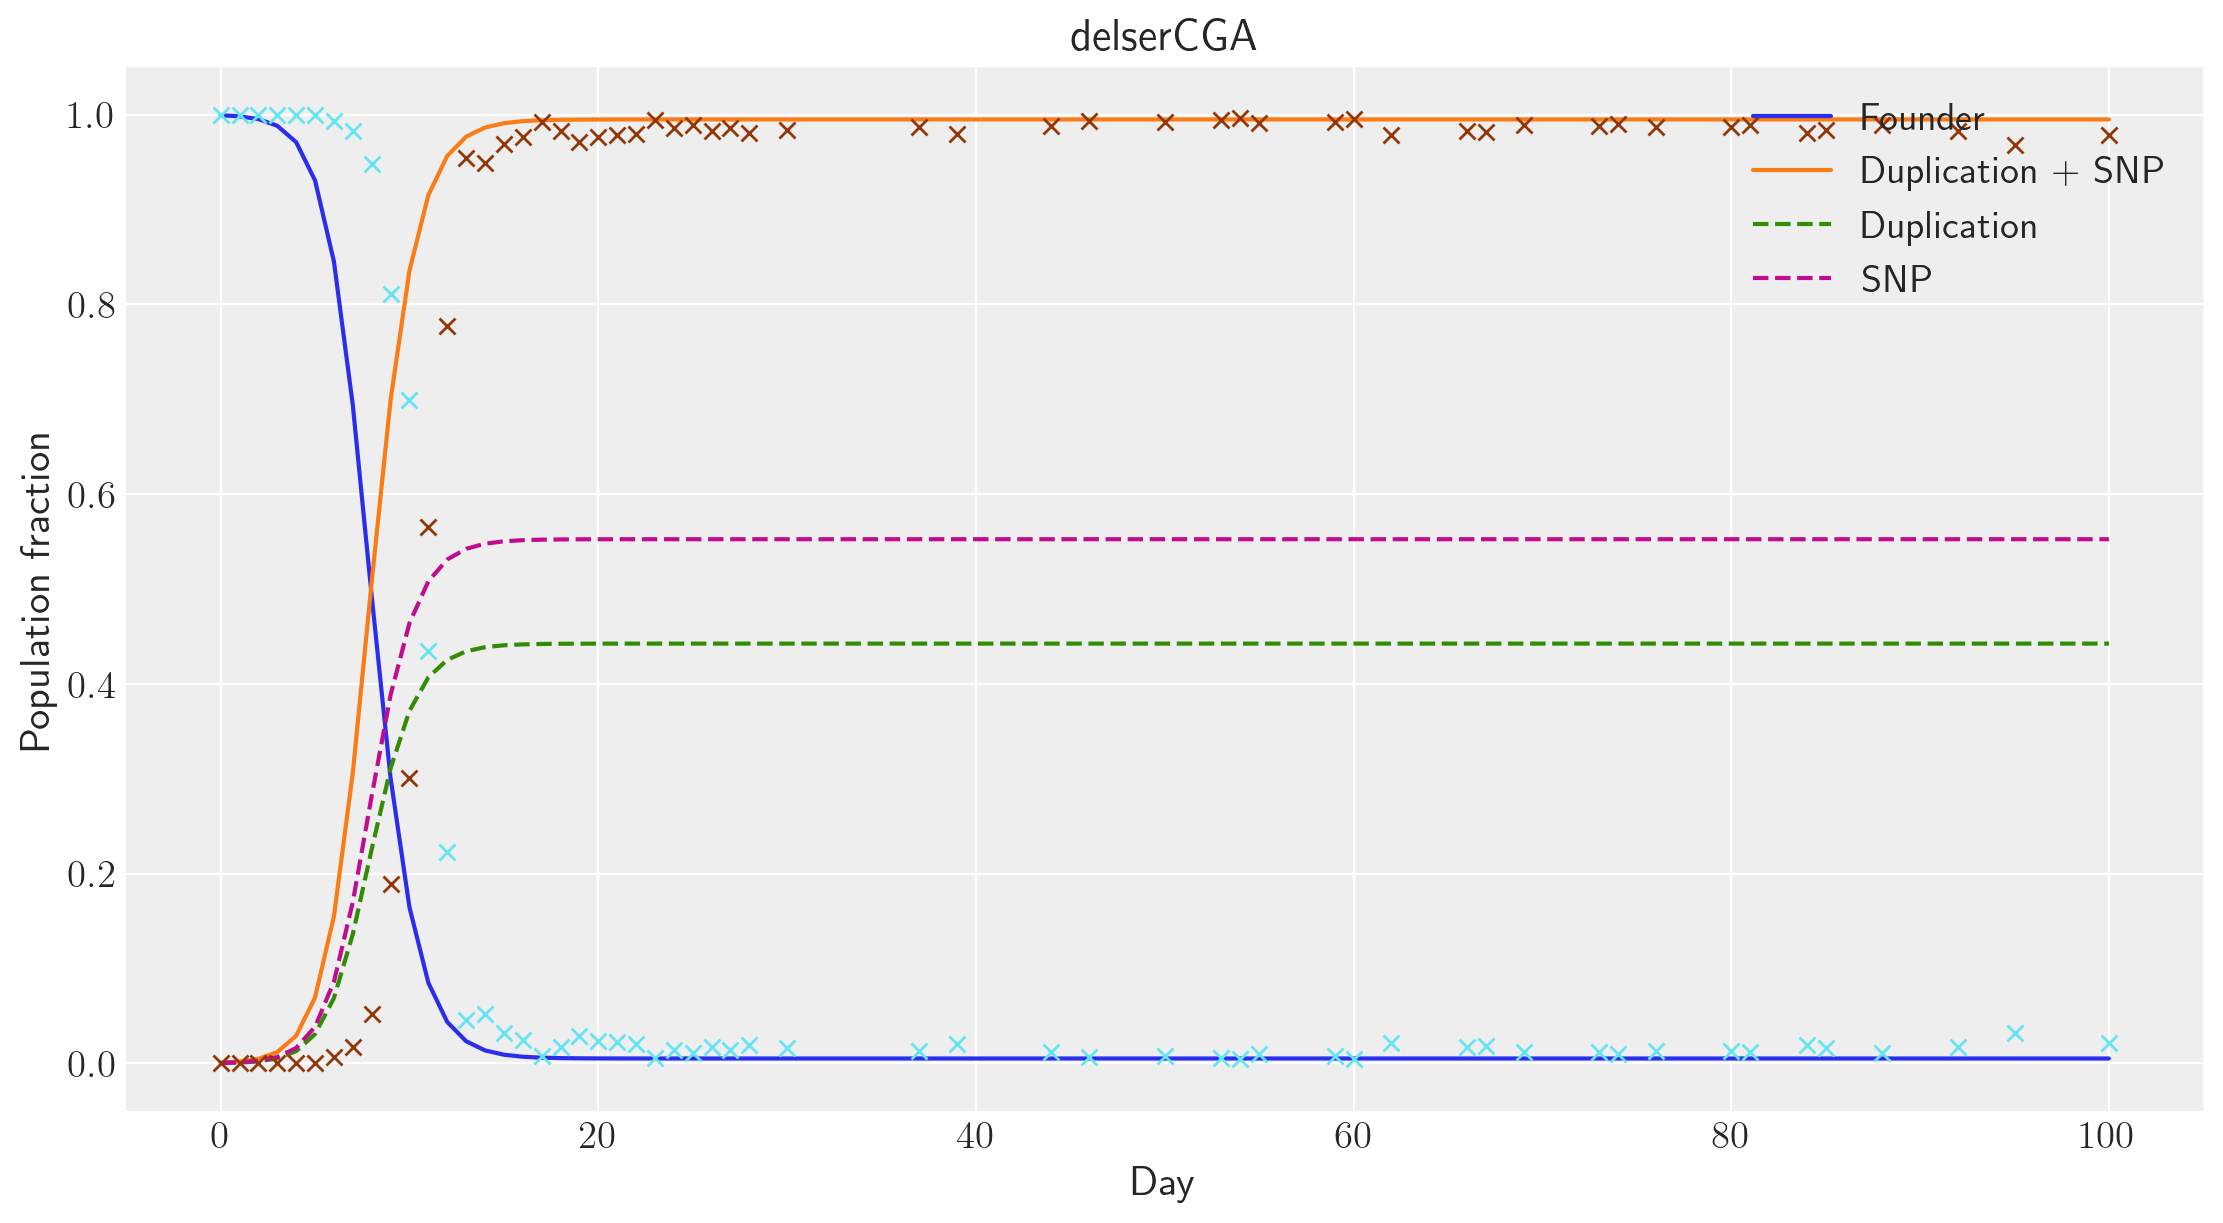

In [295]:
ax = updated_model.plot_evolution_frac()
ax.plot(temp_df.day.values , temp_df.frac_large, 'x', label = f'Replicate 1 large')
ax.plot(temp_df.day.values , temp_df.frac_small, 'x', label = f'Replicate 1 small')
plt.show()

In [302]:
0.00081, 8.1e-5

(0.00081, 8.1e-05)

In [354]:
updated_model.history.reshape(-1, 3).shape

(5858, 3)